In [16]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

from plotter import *

In [17]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

systematics = [
               'PS_weightUp','PS_weightDown',
               'PDF_weightUp','PDF_weightDown',
               'scalevar_7ptUp','scalevar_7ptDown','scalevar_3ptUp','scalevar_3ptDown'
              ]

In [18]:
deta_cut = 3.5
mjj_cut = 1000

In [19]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [20]:
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/'+str(year)+'_templates_th.pkl'
if os.path.isfile(picklename):
    repickle=False

In [21]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vbf-theory/outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vbf'].scale(scale_lumi, 'dataset')
    templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [22]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))
templates_vbf = templates.integrate('region','signal').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))

In [23]:
templates.sum('pt1','msd1','ddb1','deta','mjj').integrate('systematic', 'nominal').values()

{('ZH', 'signal'): array(14.49977654),
 ('ZH', 'muoncontrol'): array(0.10797309),
 ('WH', 'signal'): array(11.53261618),
 ('WH', 'muoncontrol'): array(0.26277508),
 ('ttH', 'signal'): array(21.93820561),
 ('ttH', 'muoncontrol'): array(4.0285125),
 ('VBF', 'signal'): array(32.65799114),
 ('VBF', 'muoncontrol'): array(0.01713745),
 ('ggF', 'signal'): array(76.85107572),
 ('ggF', 'muoncontrol'): array(0.),
 ('ggF-powheg', 'signal'): array(156.59744104),
 ('ggF-powheg', 'muoncontrol'): array(0.),
 ('QCD', 'signal'): array(4008994.44349956),
 ('QCD', 'muoncontrol'): array(224.31635034),
 ('VV', 'signal'): array(1288.31171203),
 ('VV', 'muoncontrol'): array(2.72936647),
 ('Wjets', 'signal'): array(91422.5409035),
 ('Wjets', 'muoncontrol'): array(125.18982904),
 ('Zjets', 'signal'): array(43273.63568808),
 ('Zjets', 'muoncontrol'): array(31.67554405),
 ('ttbar', 'signal'): array(19757.76935944),
 ('ttbar', 'muoncontrol'): array(1968.98540053),
 ('singlet', 'signal'): array(3109.76280939),
 ('

In [24]:
os.system('rm '+year+'/1-signalregion-th.root')
fout = uproot3.create(year+'/1-signalregion-th.root')
for p in pmap.keys():  
    if p == "ttH" and year == '2016':
        continue
    print(p)
    if "data" not in p:
        for s in systematics:
            h = templates_vbf.sum('pt1').integrate('systematic',s).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
            fout["pass_"+p+"_"+s] = hist.export1d(h)
            h = templates_vbf.sum('pt1').integrate('systematic',s).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
            fout["fail_"+p+"_"+s] = hist.export1d(h)

fout.close()

ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata


In [25]:
ptbins = [450, 550, 1200]
os.system('rm '+year+'/2pt-signalregion-th.root')
fout = uproot3.create(year+'/2pt-signalregion-th.root')

for i,b in enumerate(ptbins[:-1]):
    for p in pmap.keys(): 
        if p == "ttH" and year == '2016':
            continue
        print(p)
        if "data" in p:
            s = "nominal"
            h = templates_vbf.integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
            fout["pass_pt"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
            h = templates_vbf.integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
            fout["fail_pt"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
        else:
            for s in systematics:
                h = templates_vbf.integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
                fout["pass_pt"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
                h = templates_vbf.integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
                fout["fail_pt"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)

fout.close()

ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata


In [26]:
mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH']

In [27]:
h = templates.sum('pt1','ddb1').integrate('region','signal').integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000))
g = templates.sum('pt1').integrate('region','signal').integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000)).integrate('ddb1',int_range=slice(0.89,1))

/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/no

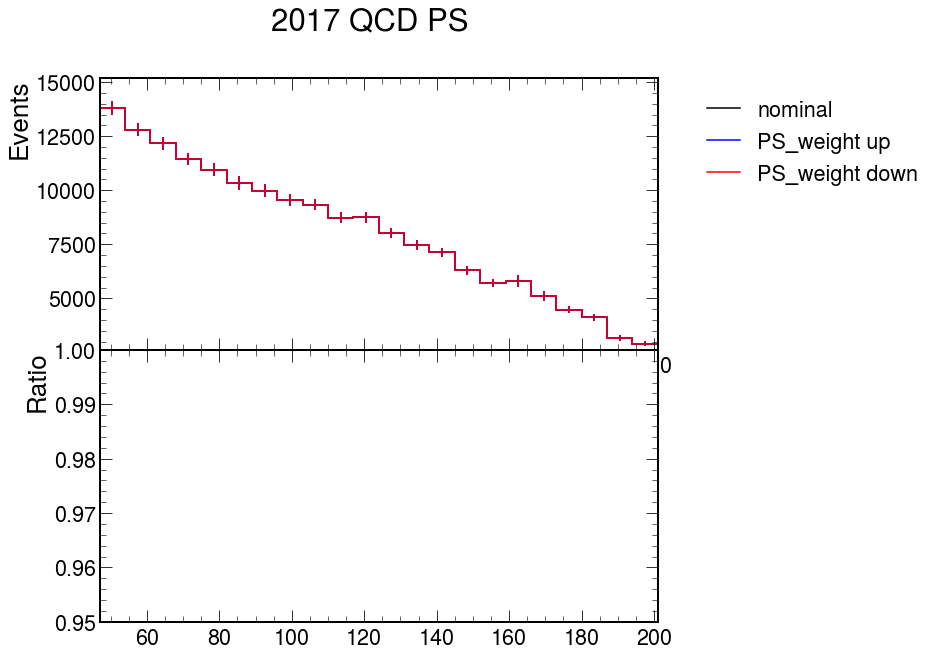

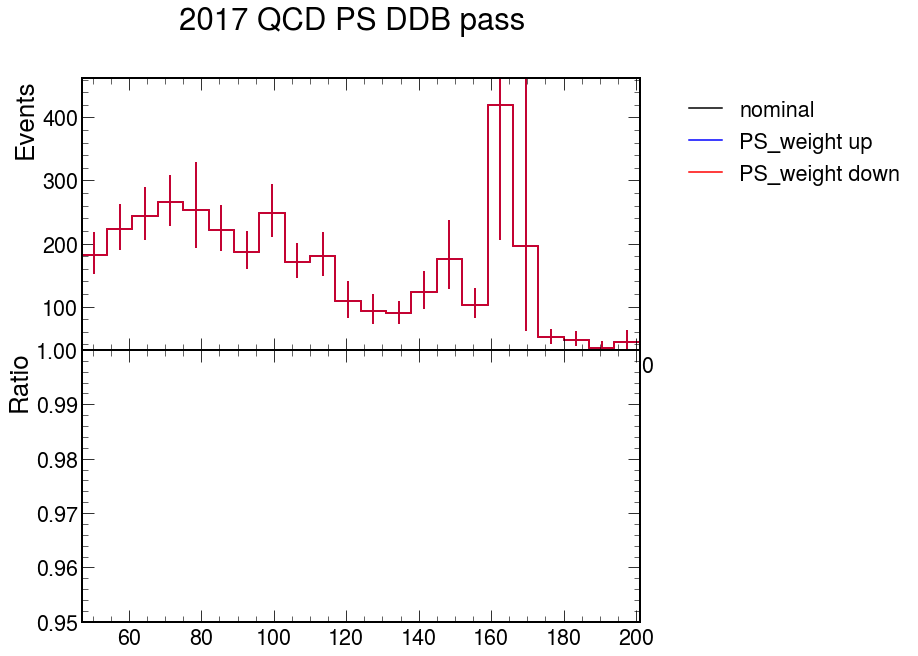

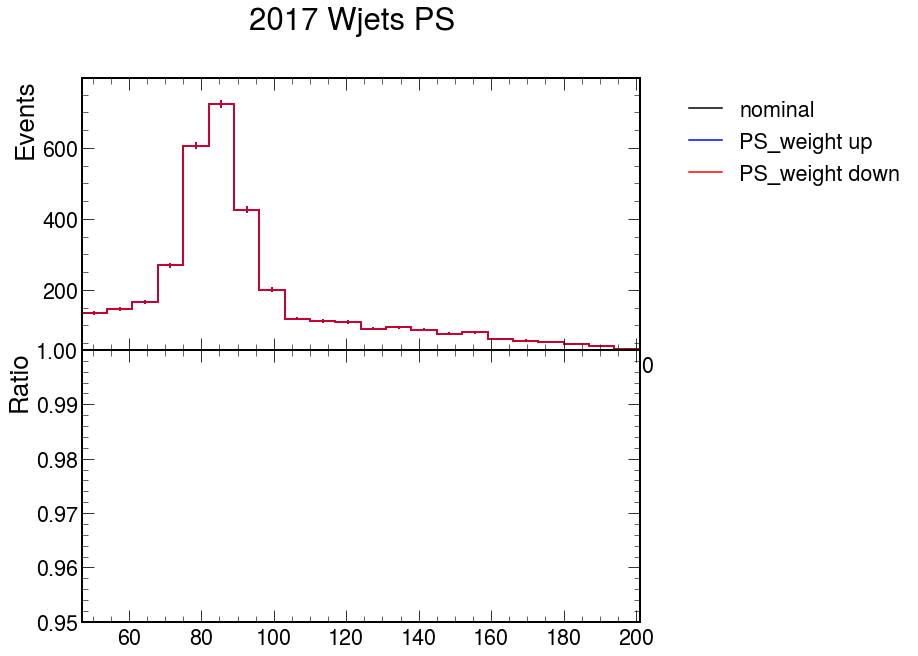

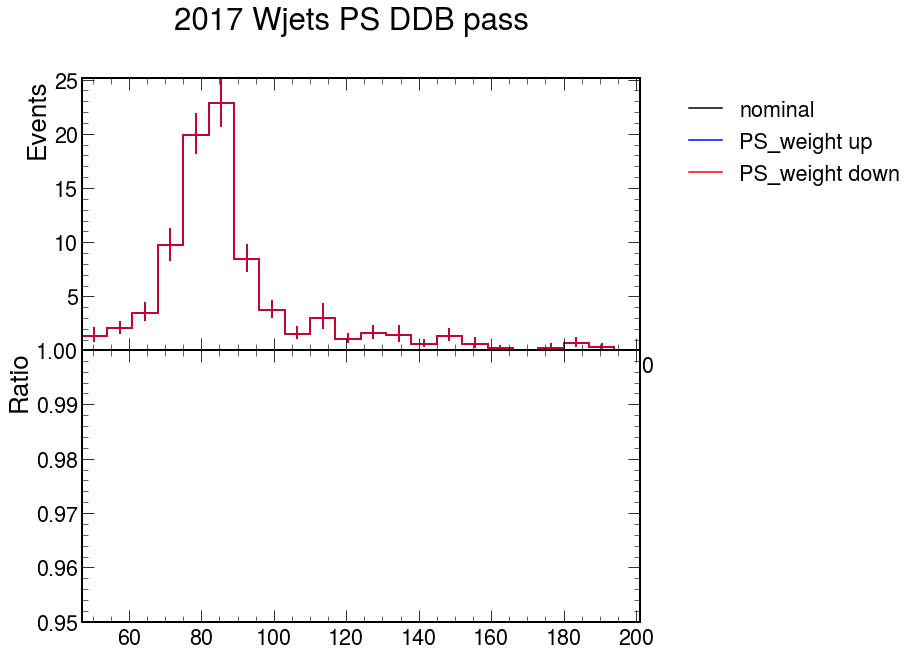

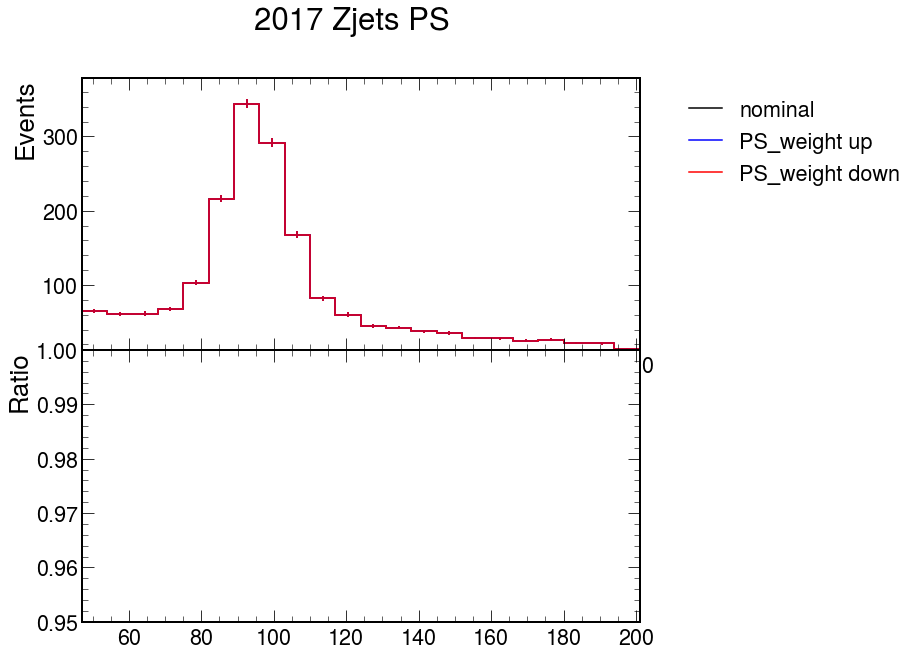

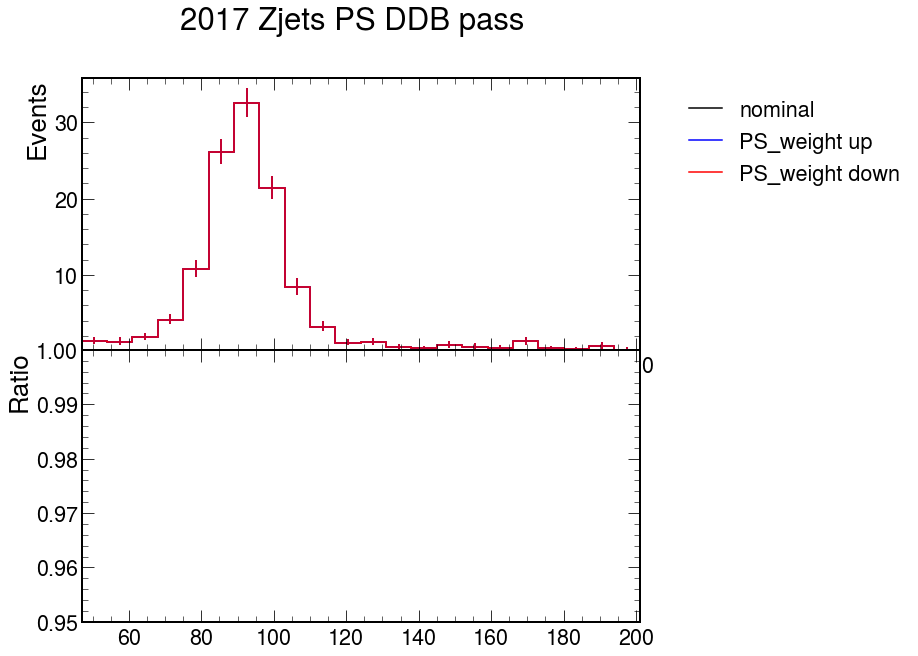

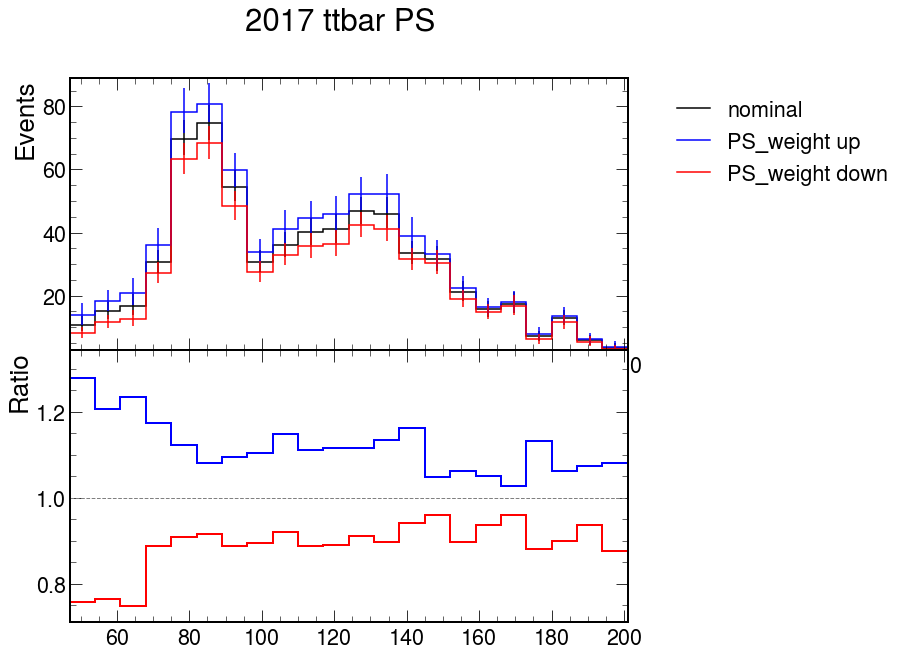

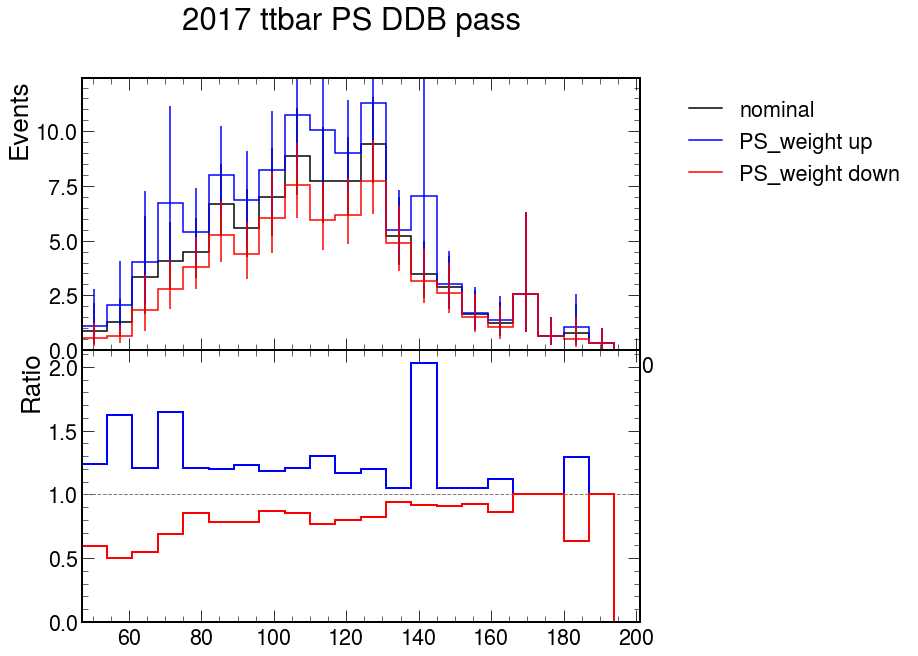

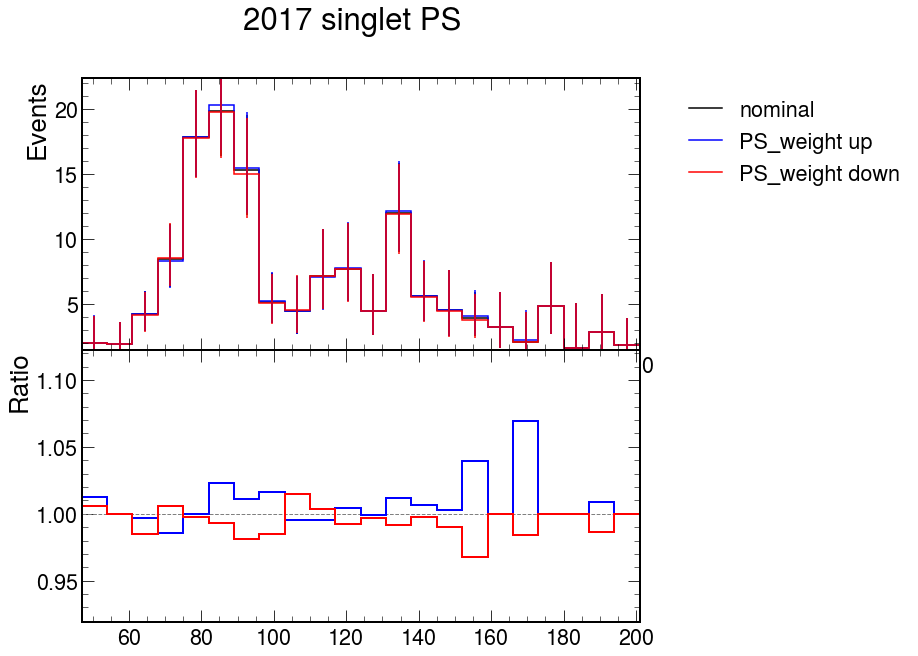

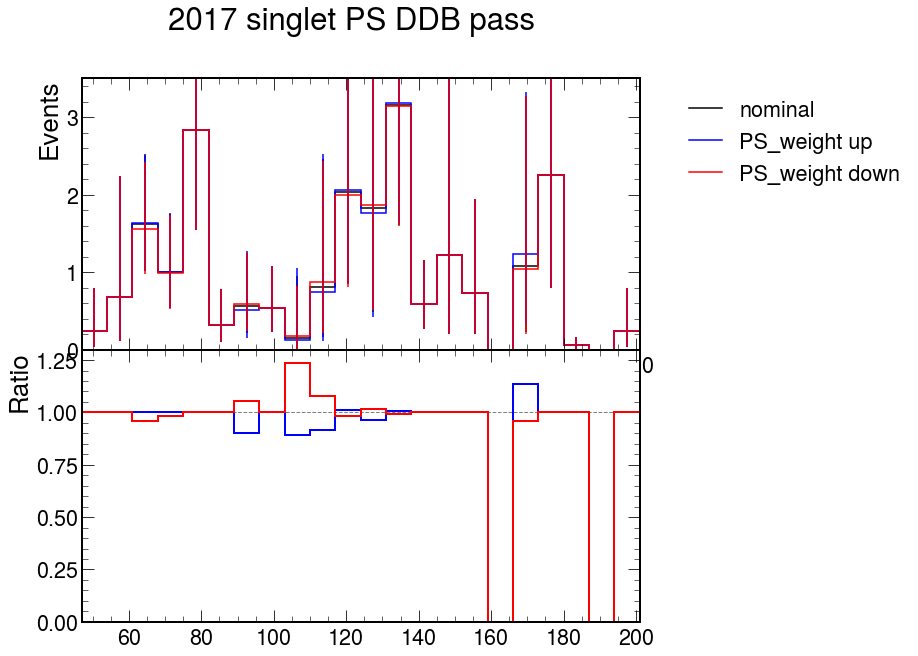

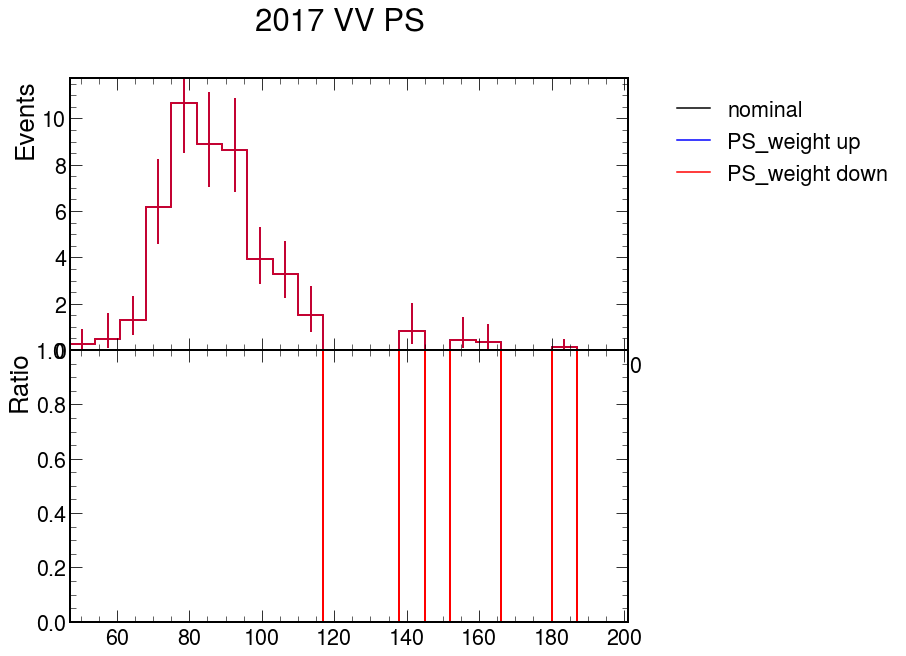

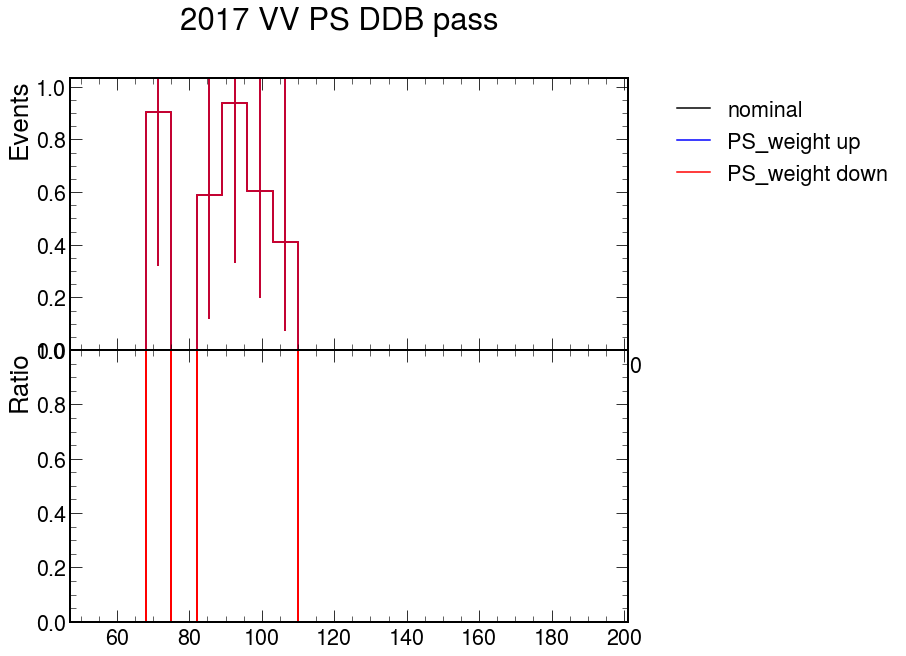

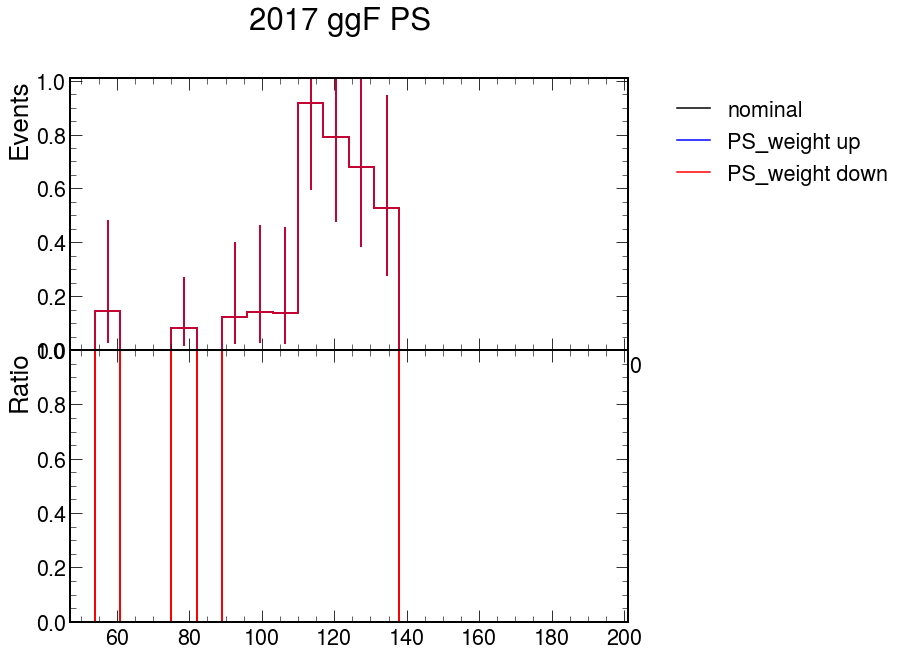

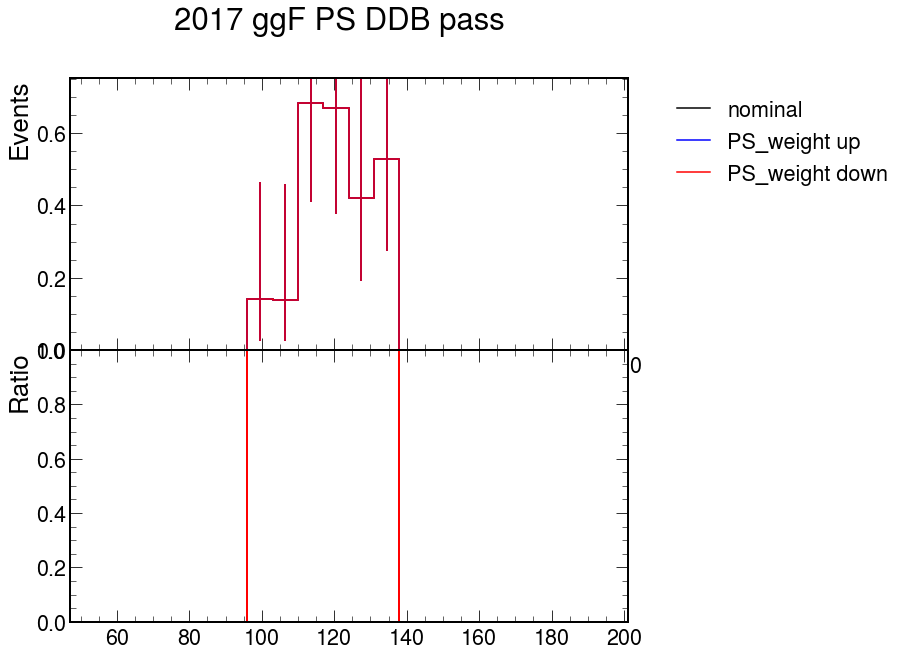

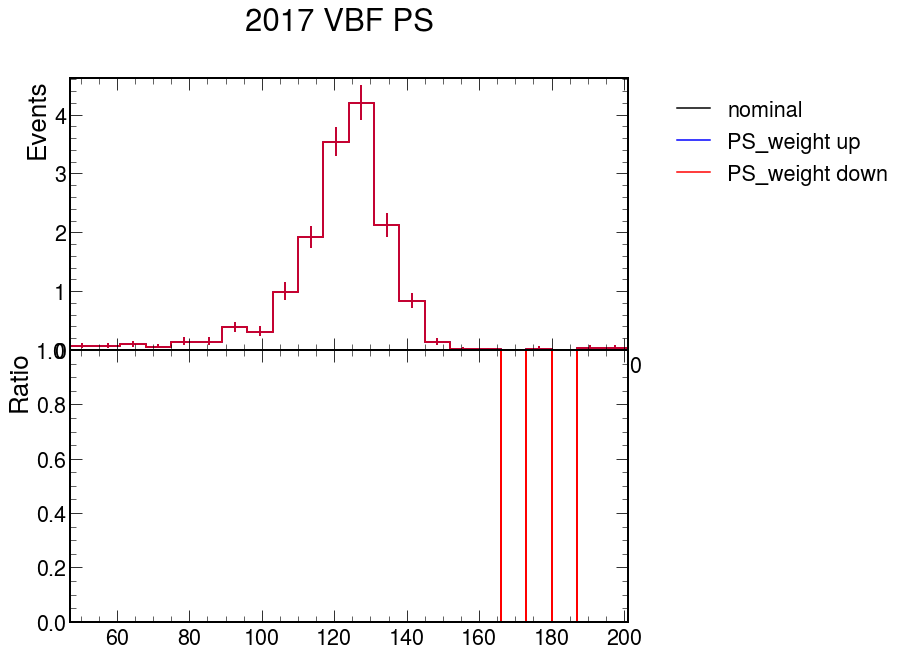

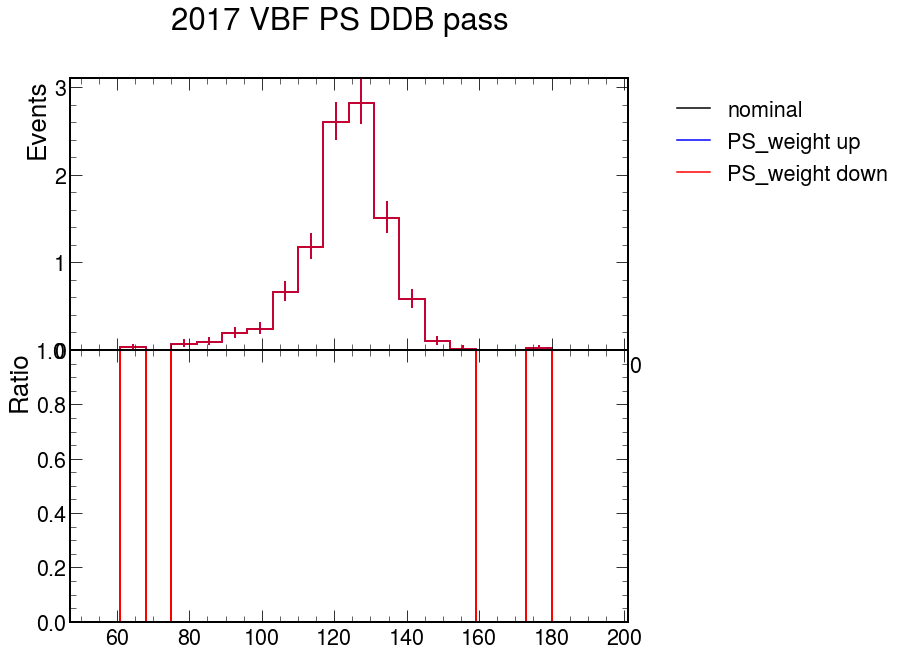

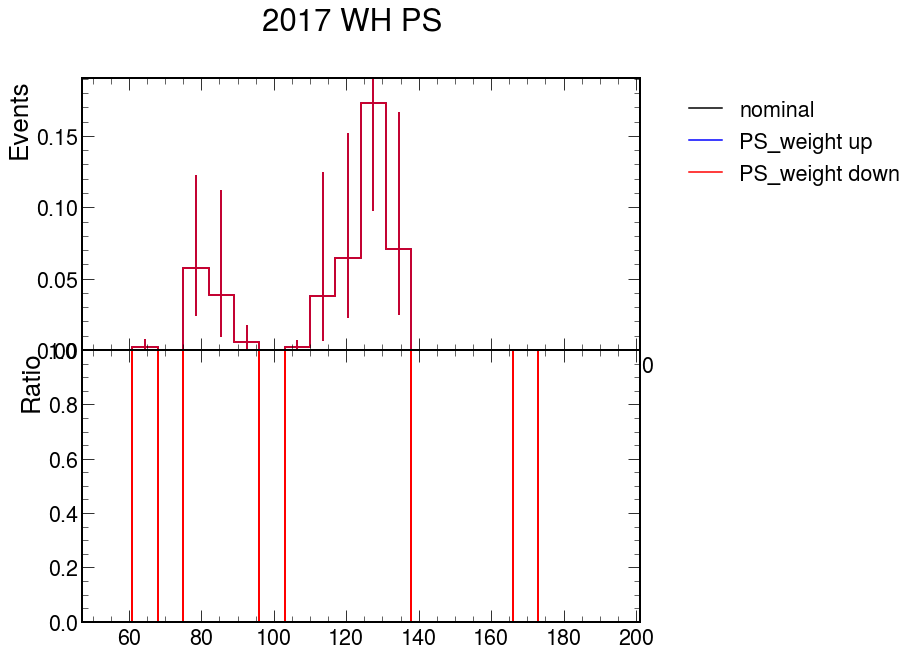

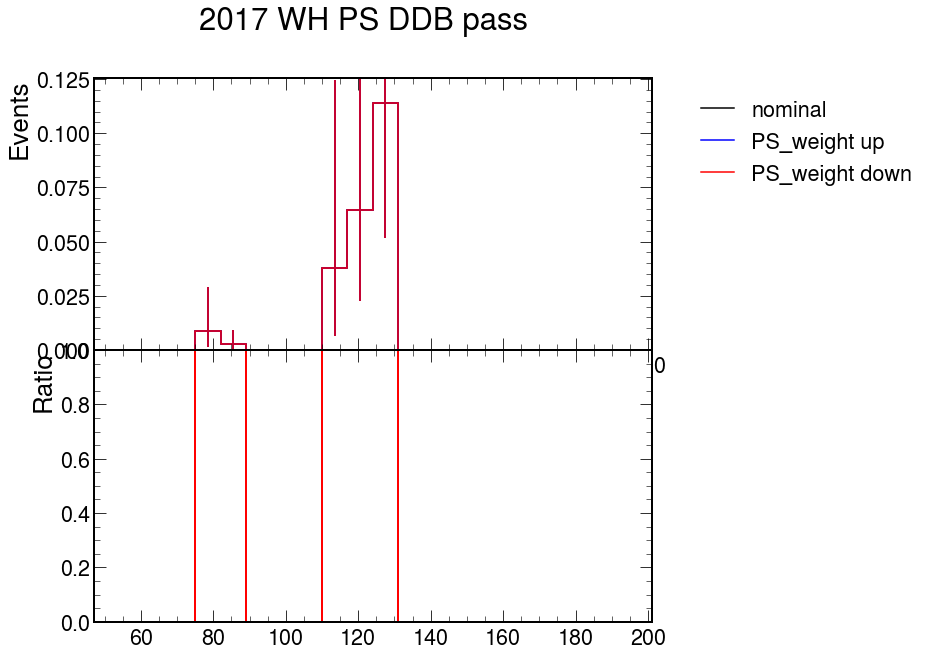

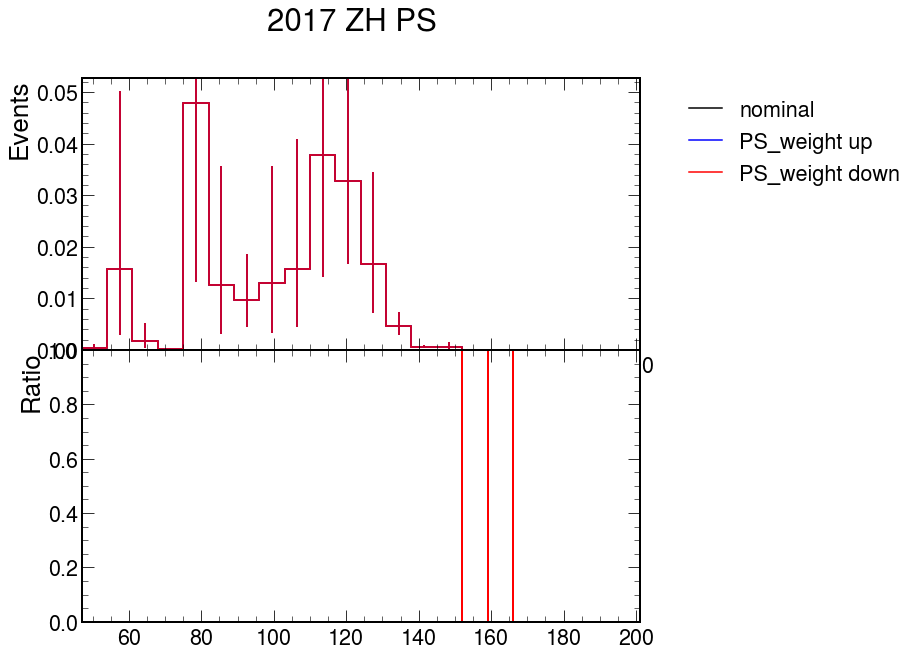

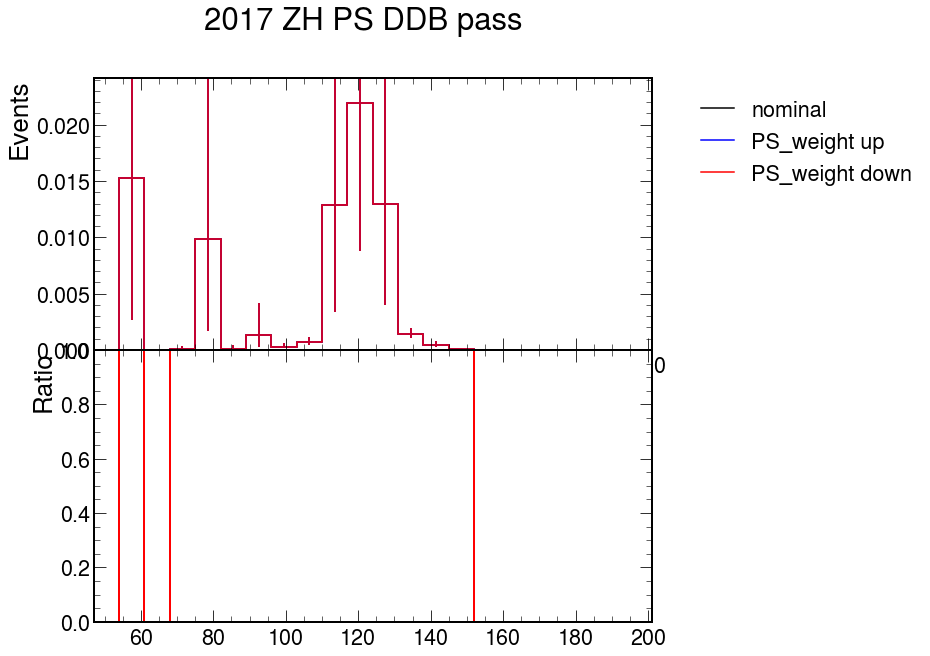

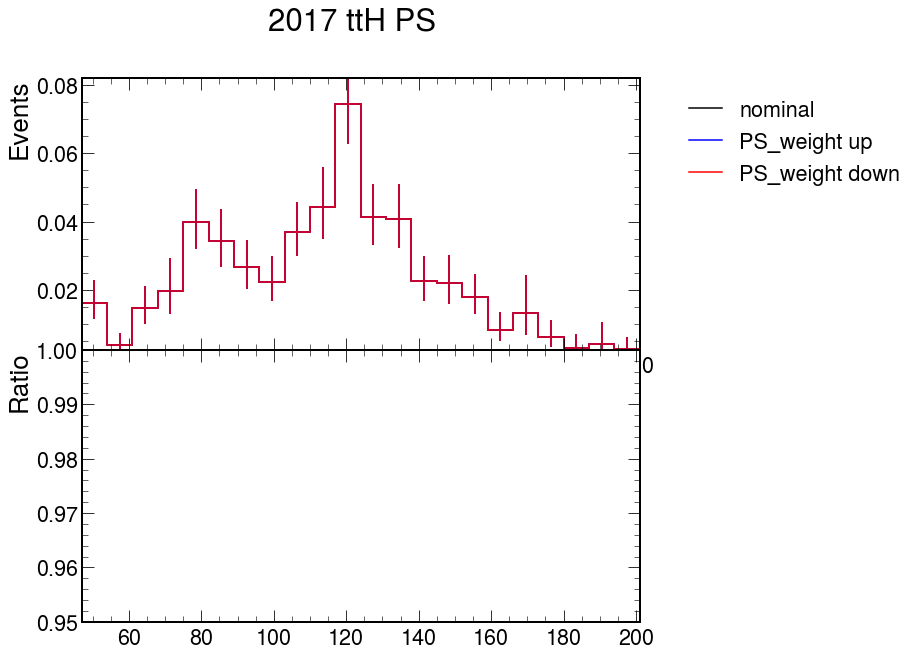

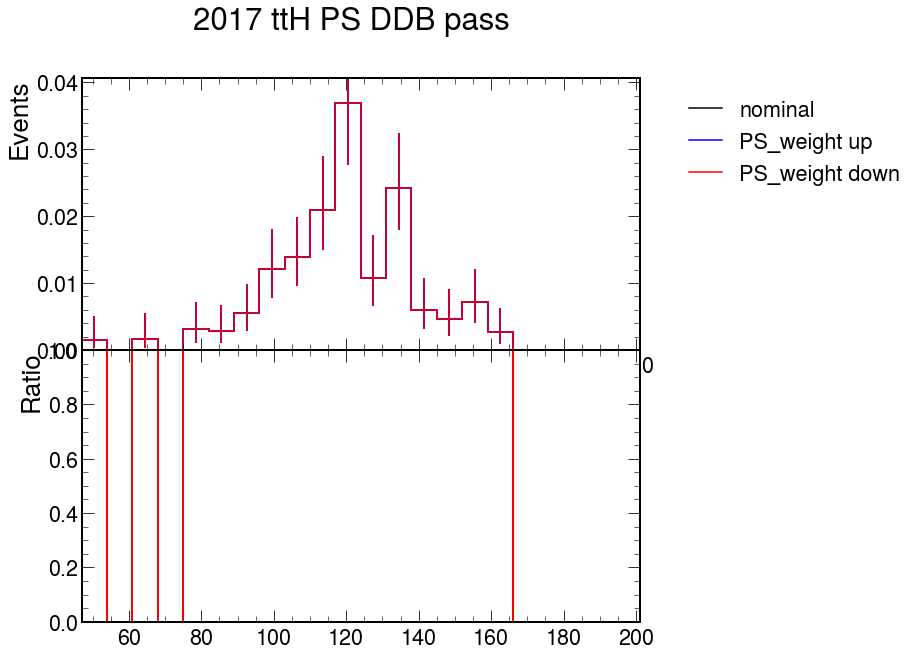

In [28]:
for p in mc:
    plot_syst(h.integrate('process',p),'PS_weight',year + ' ' + p + ' PS', year+'/syst_PS_weight/'+p)
    plot_syst(g.integrate('process',p),'PS_weight',year + ' ' + p + ' PS DDB pass', year+'/syst_PS_weight/'+p+"_pass_weight")

/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/no

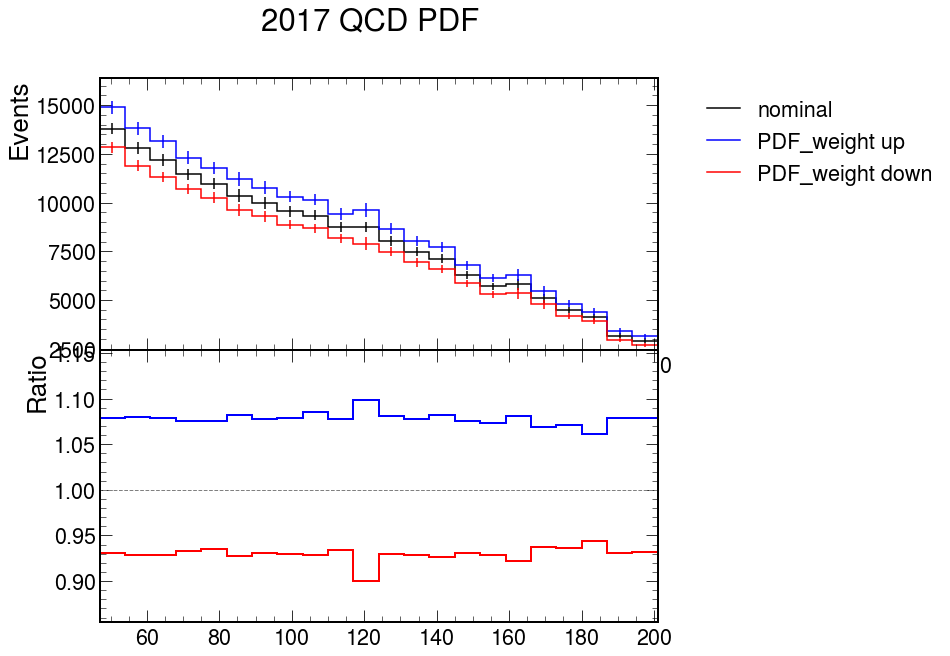

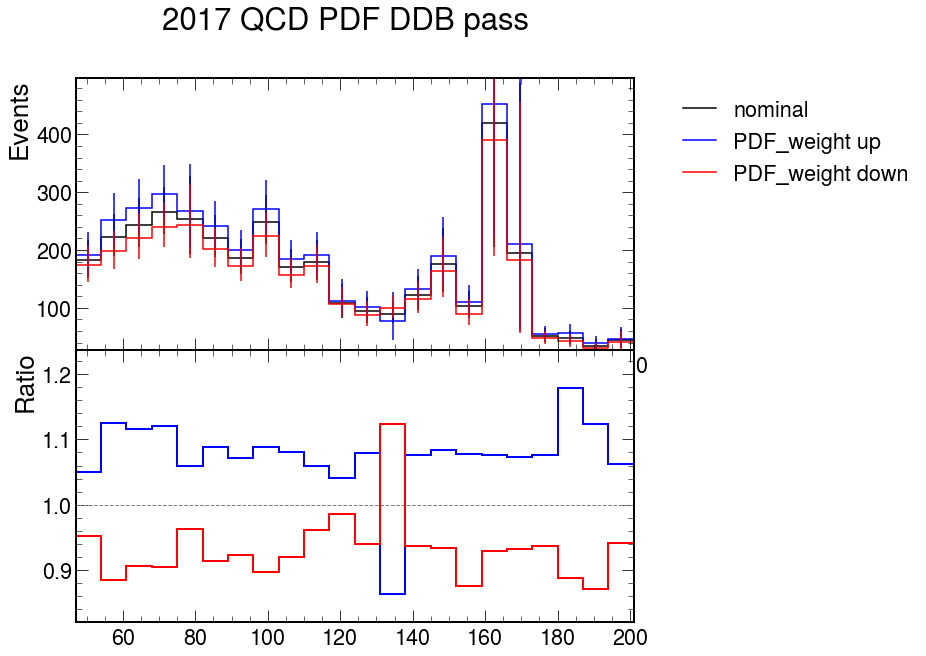

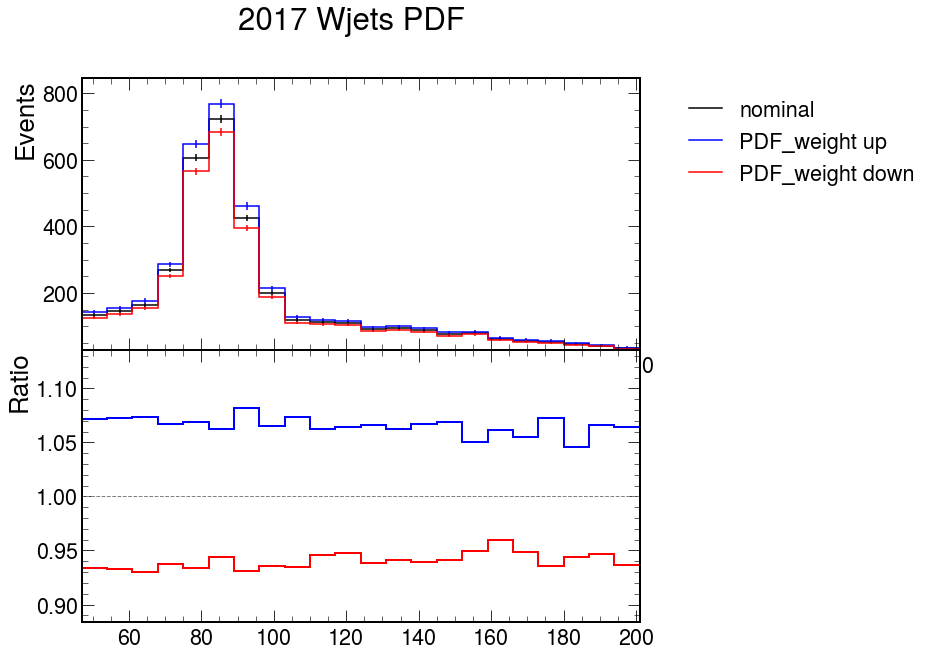

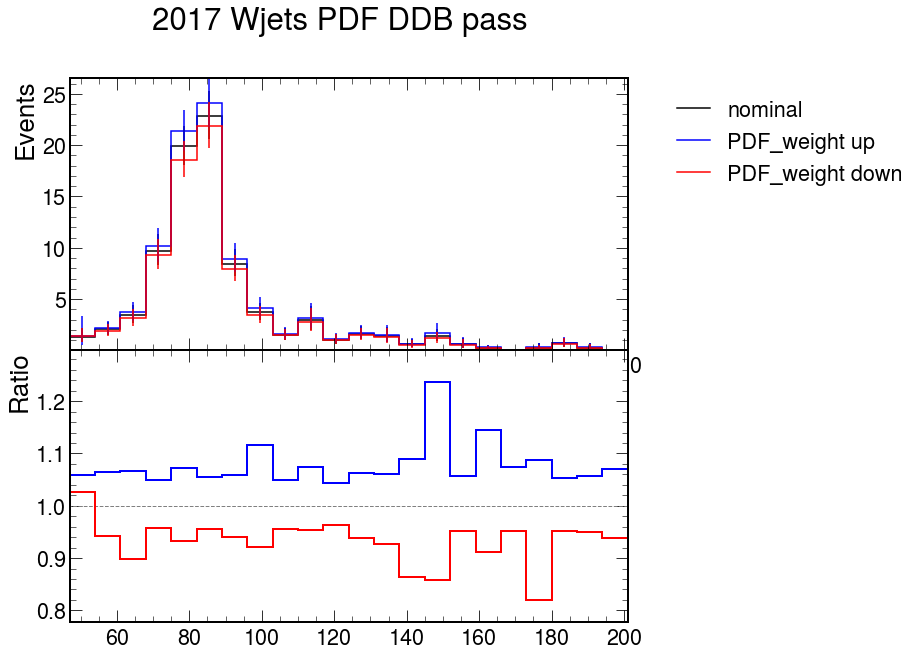

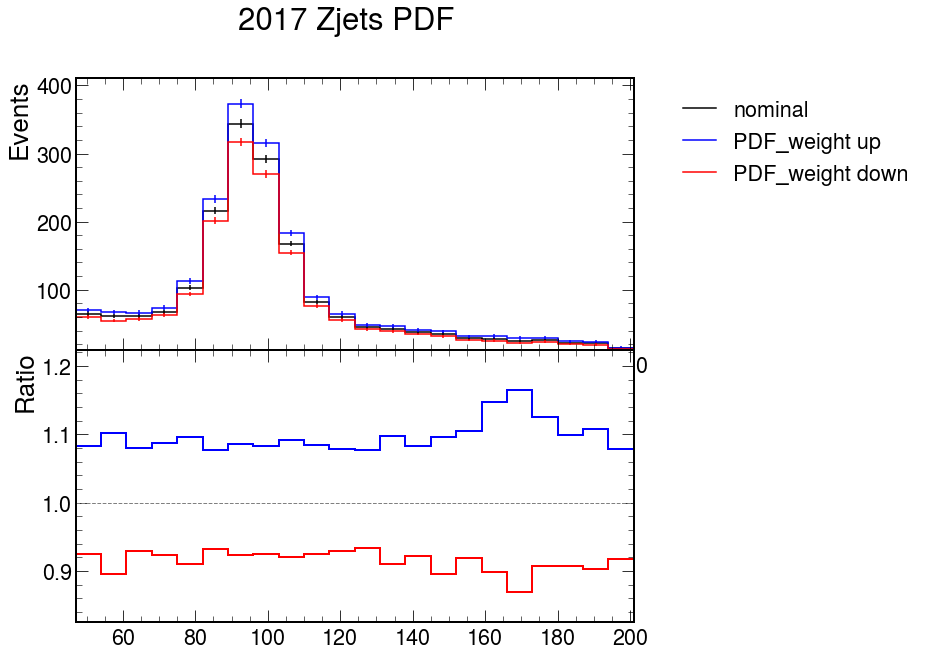

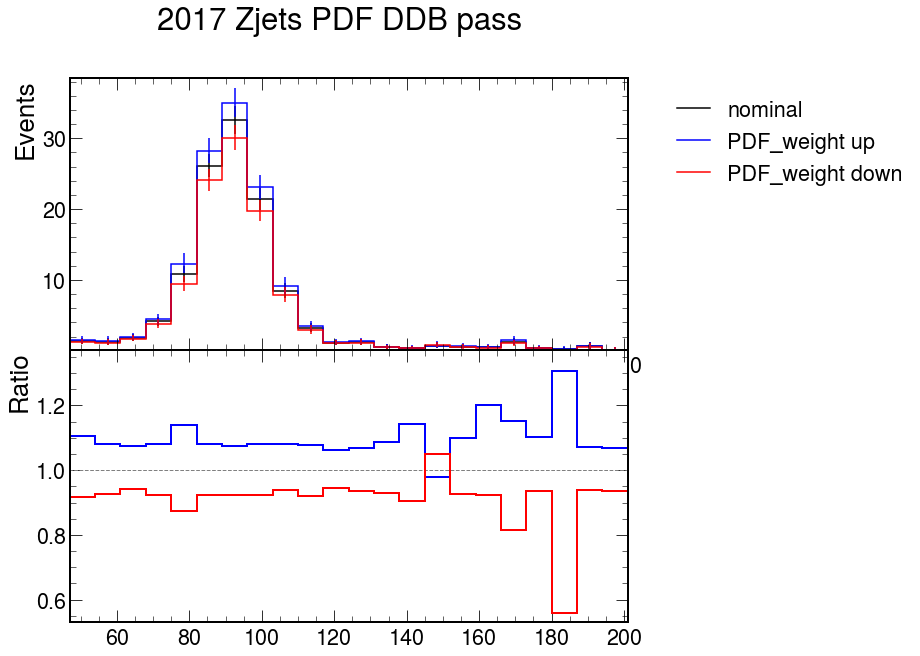

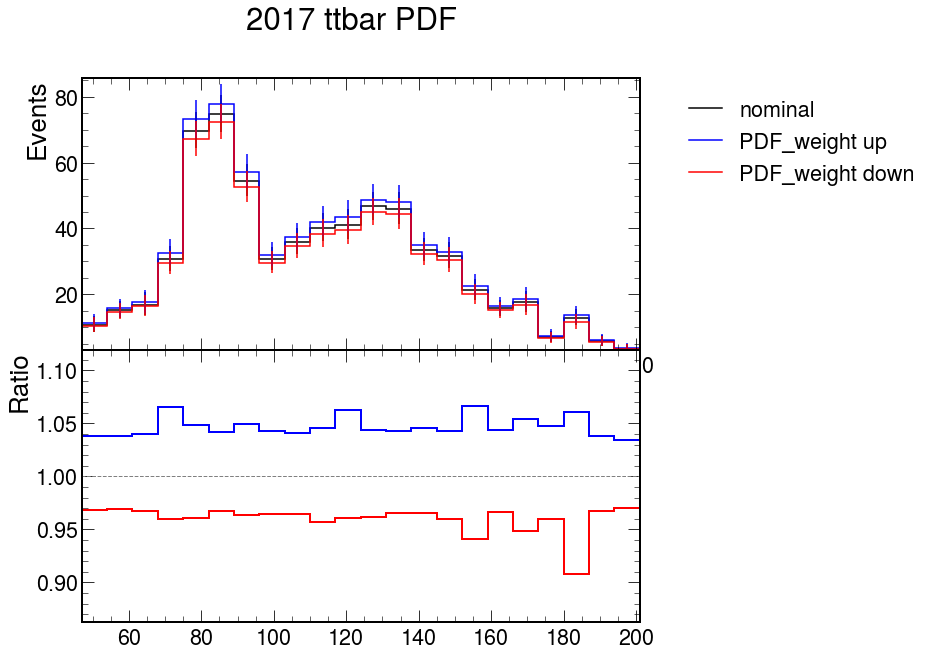

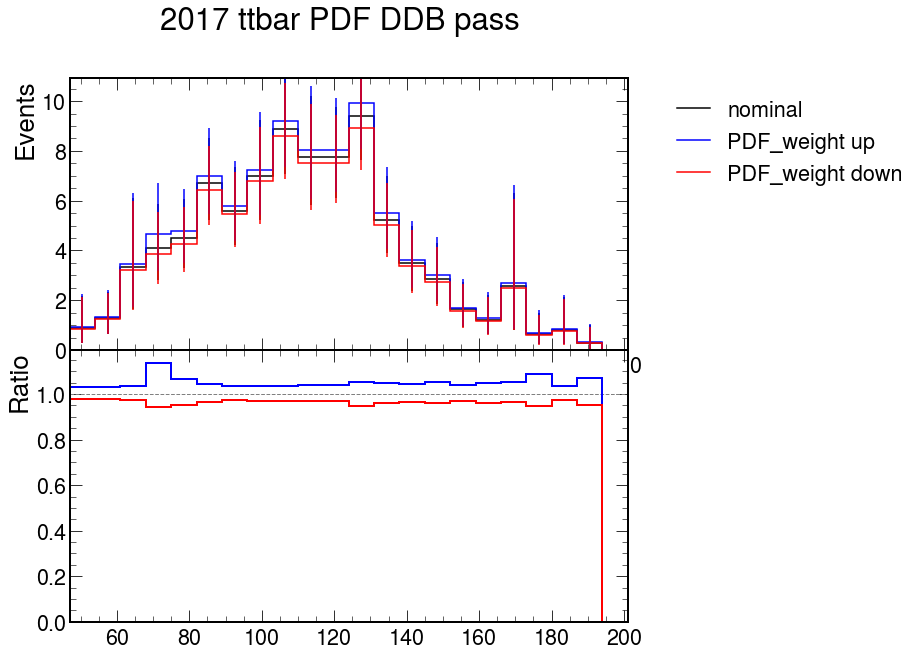

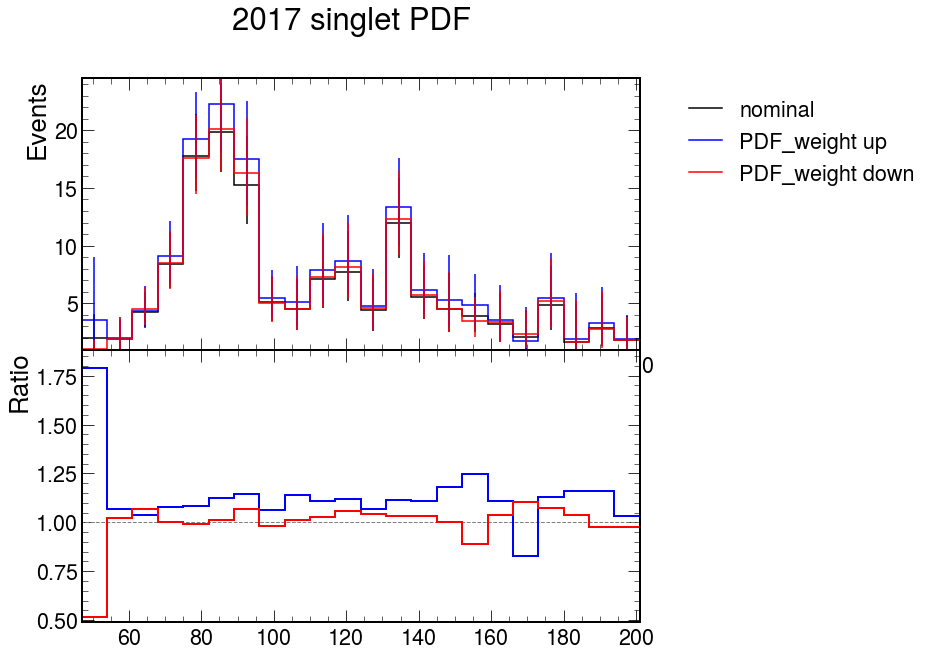

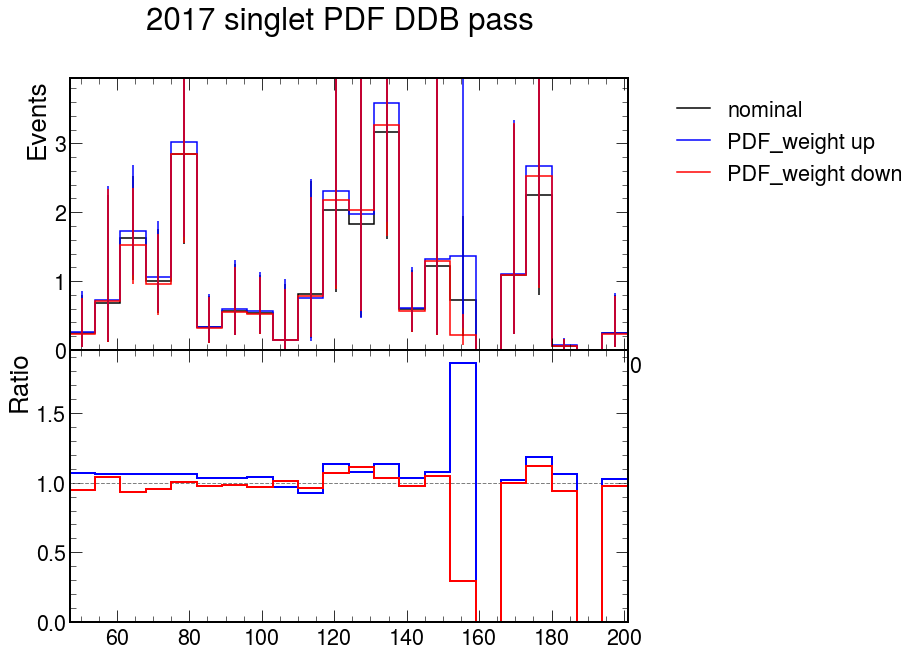

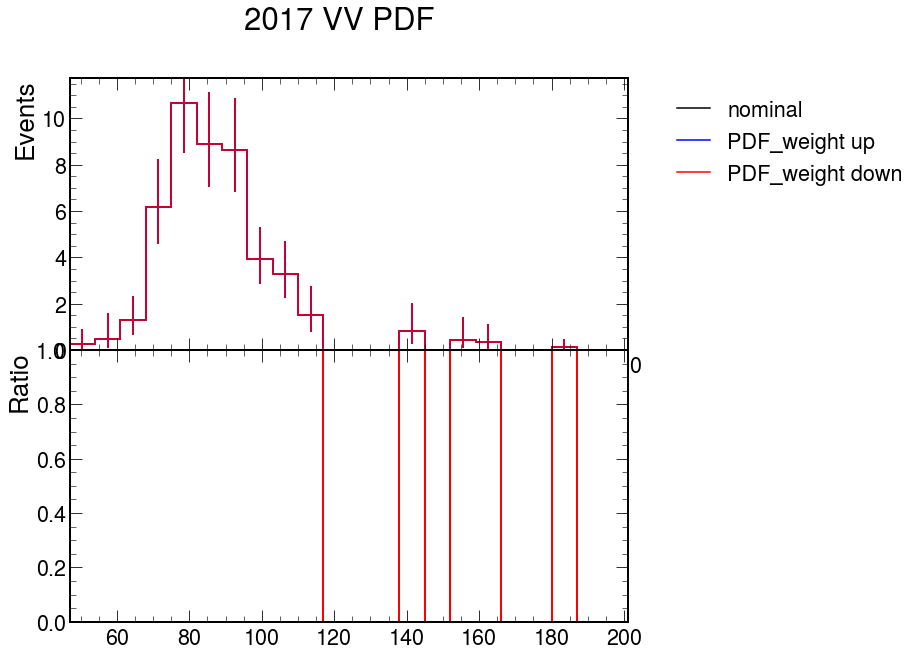

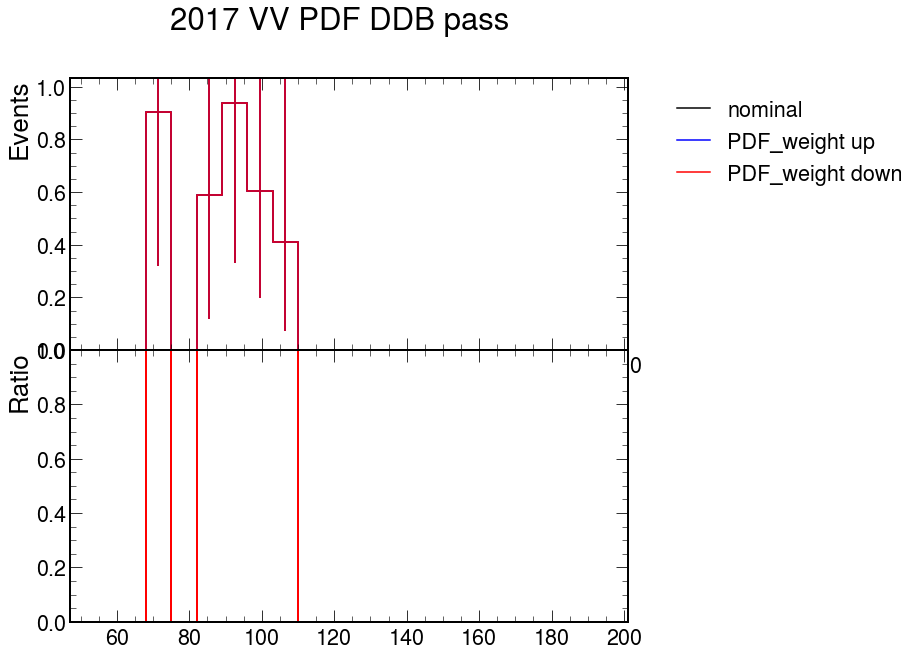

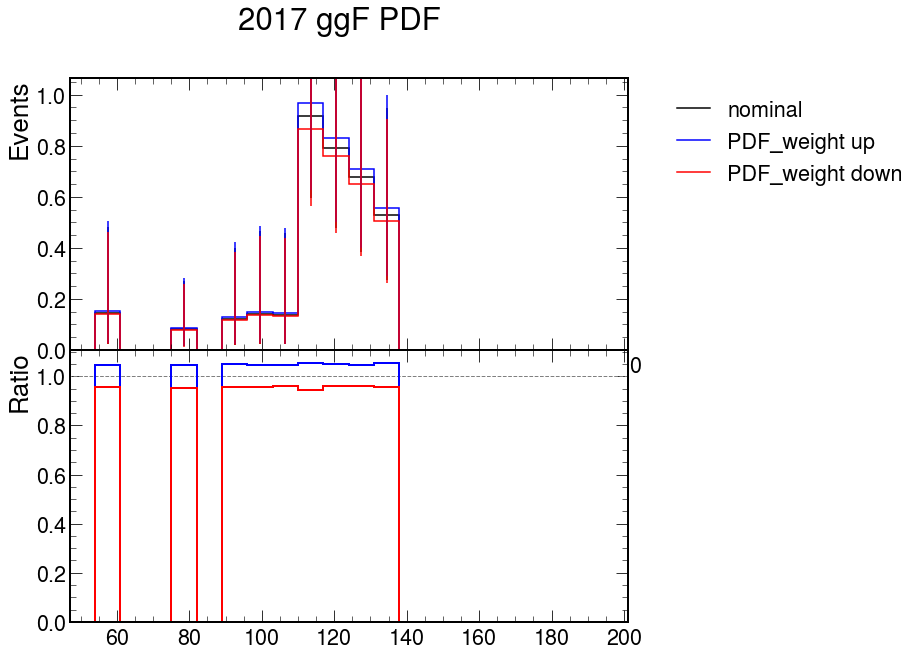

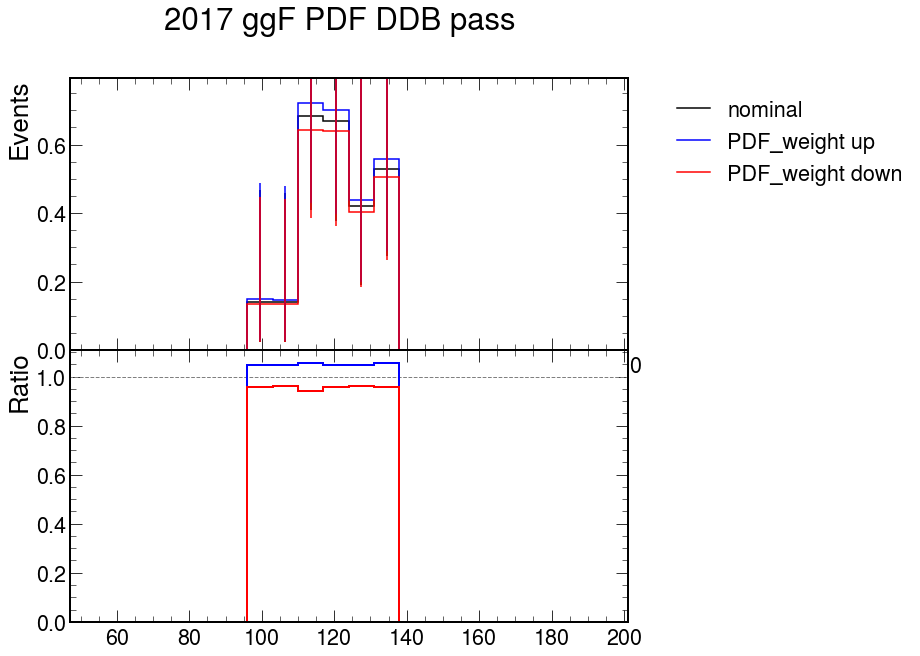

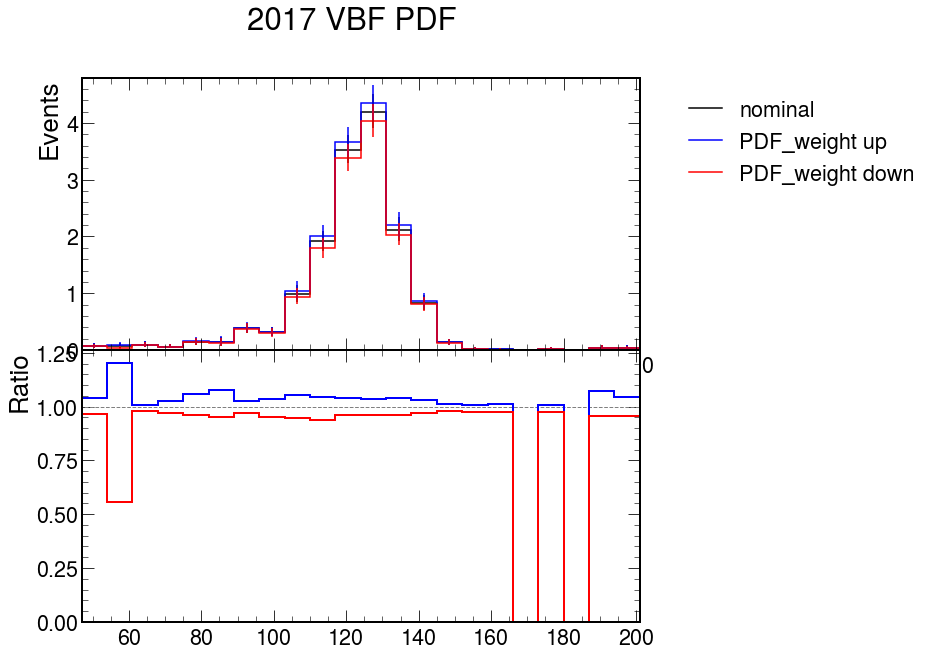

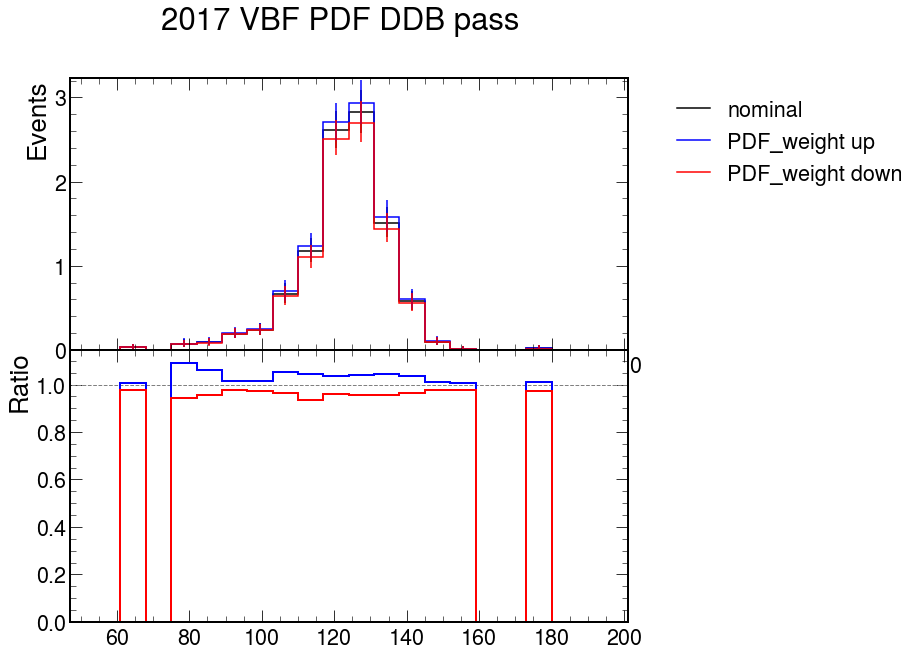

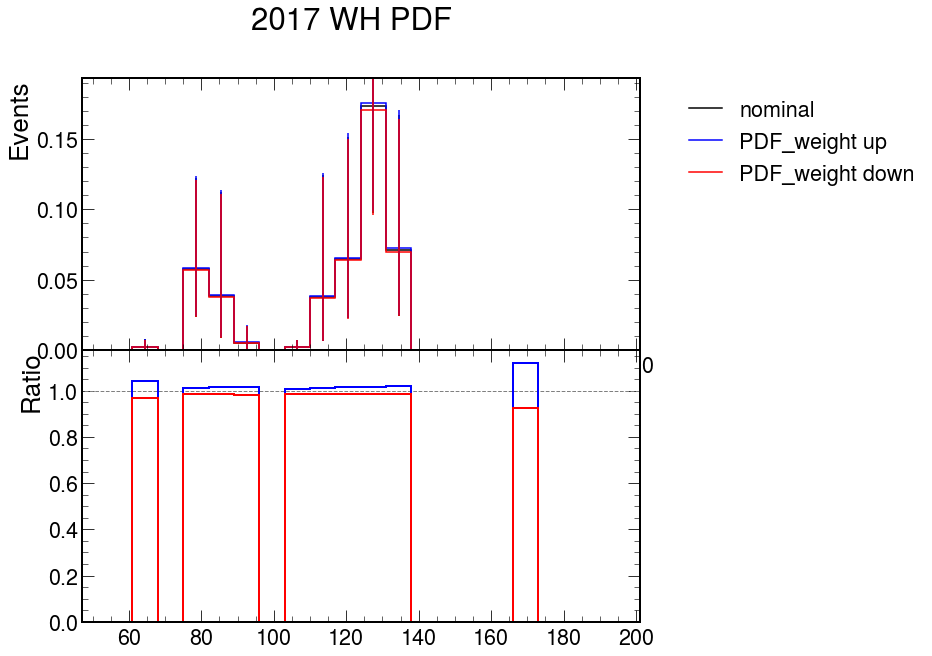

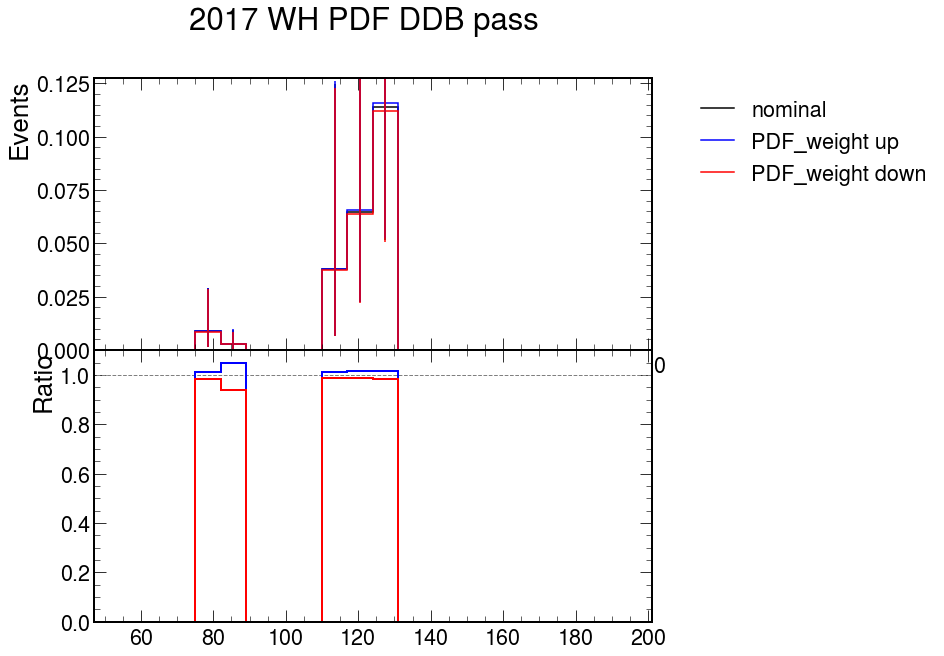

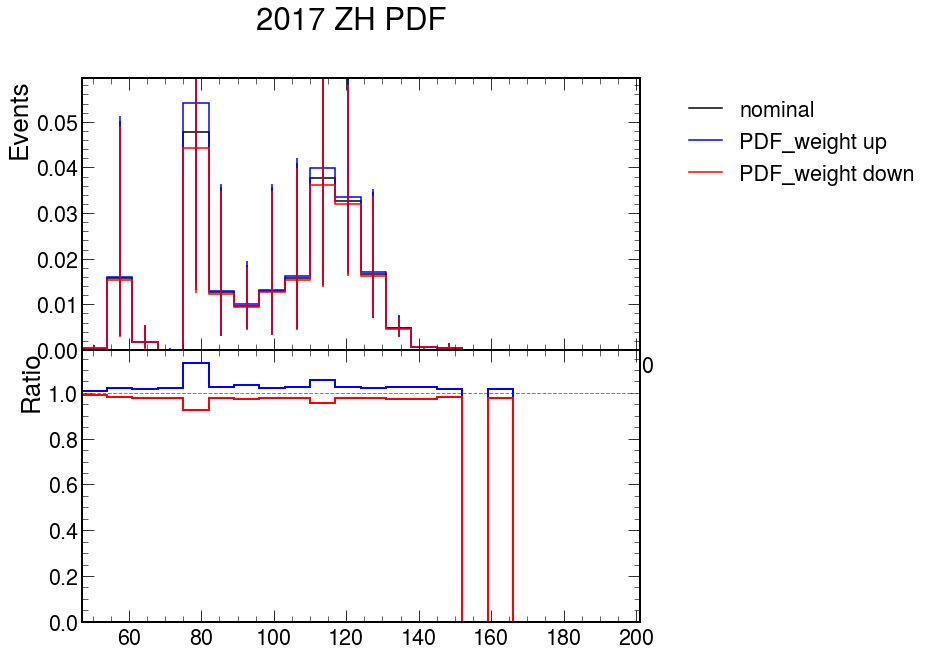

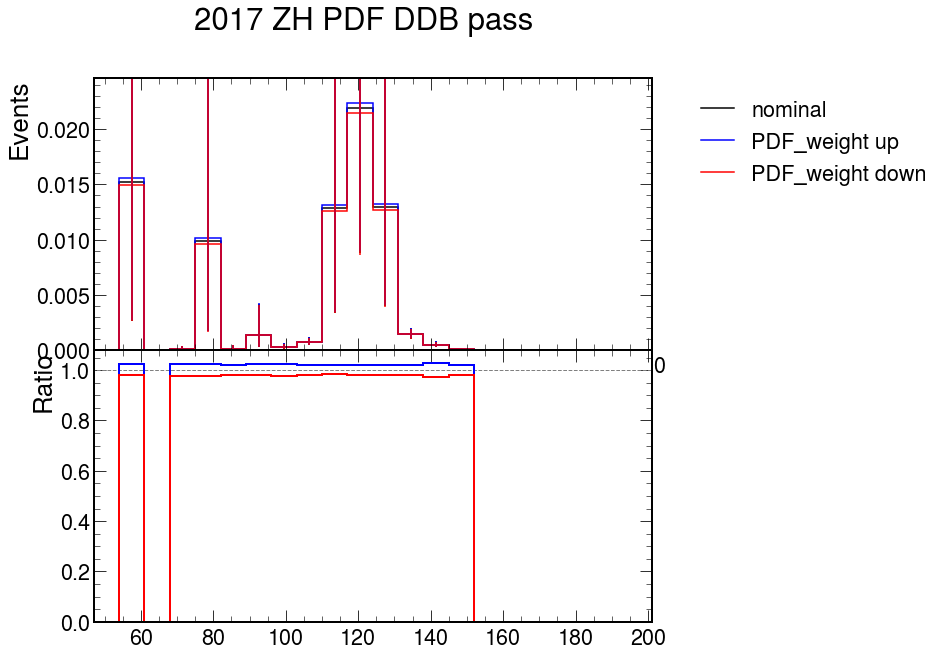

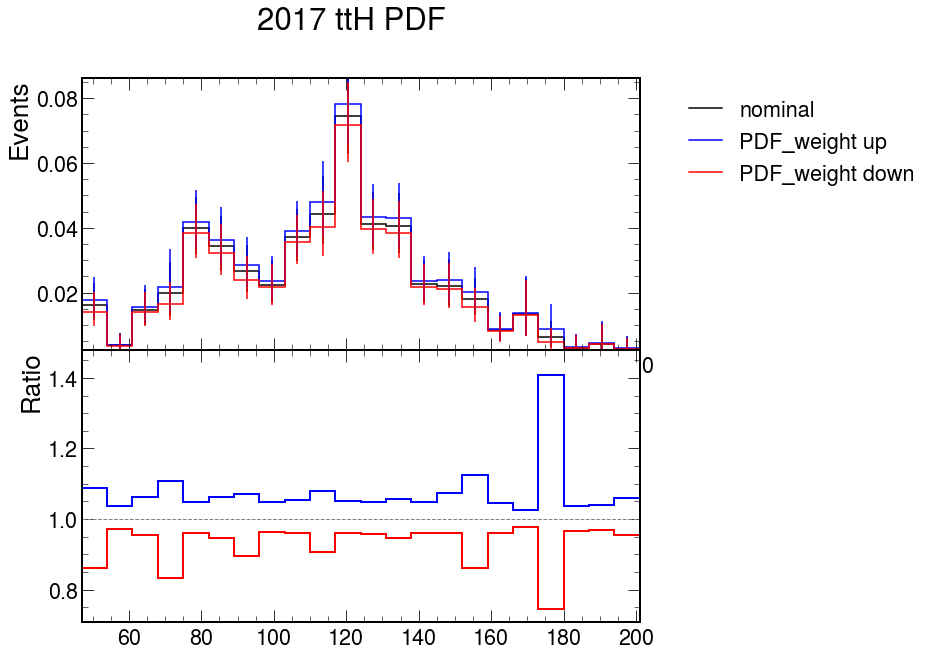

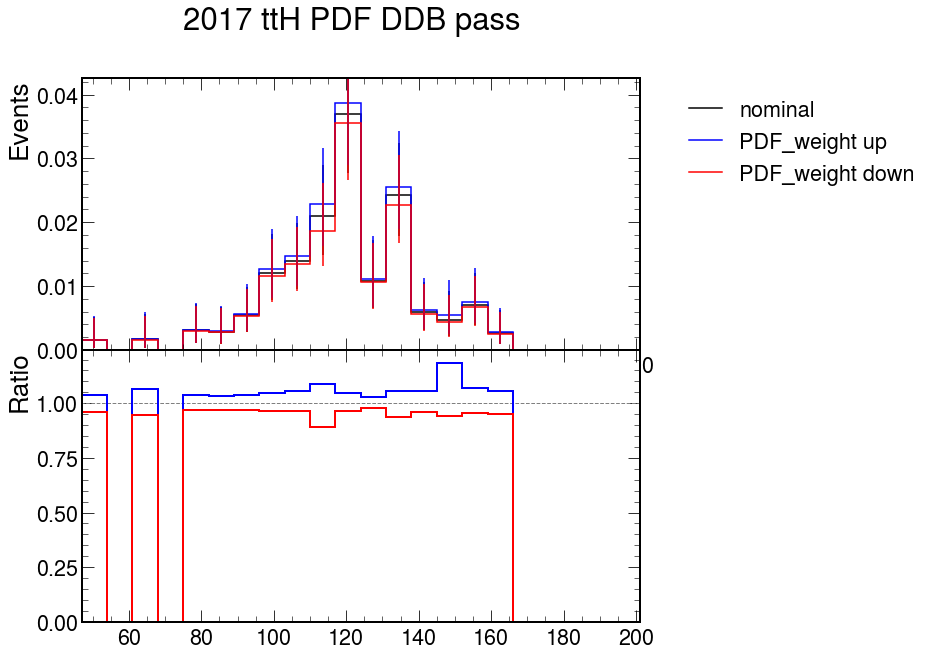

In [29]:
for p in mc:
    plot_syst(h.integrate('process',p),'PDF_weight',year+' '+p + ' PDF',year+'/syst_PDF_weight/'+p)
    plot_syst(g.integrate('process',p),'PDF_weight',year + ' ' + p + ' PDF DDB pass', year+'/syst_PDF_weight/'+p+"_pass")

/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/no

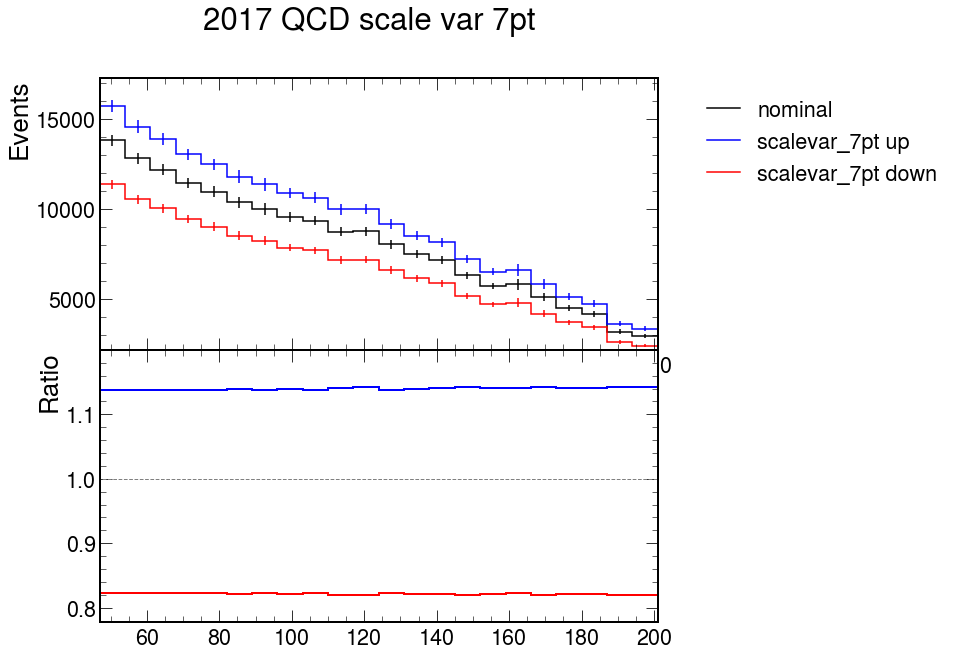

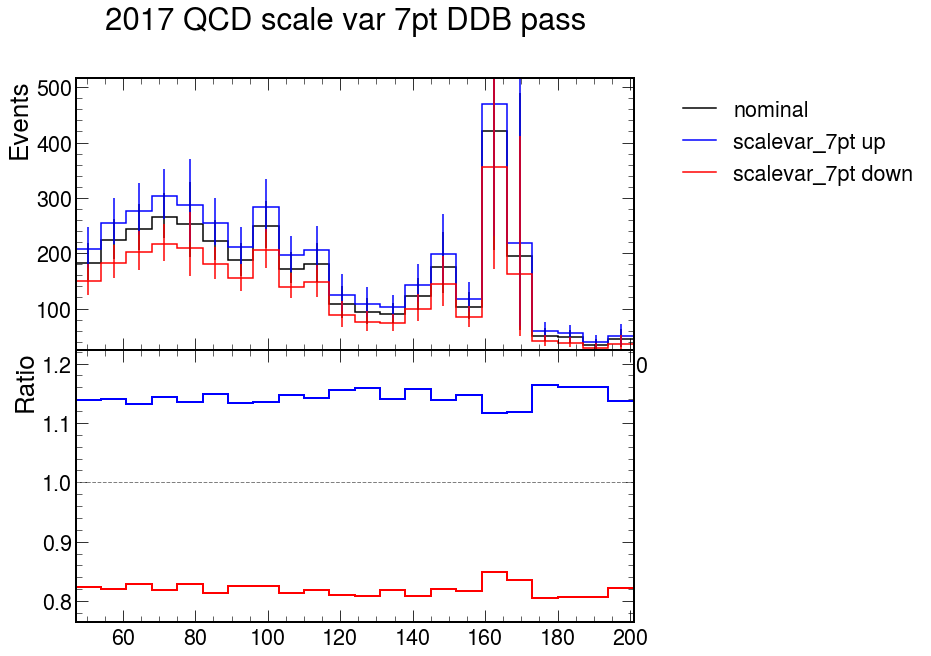

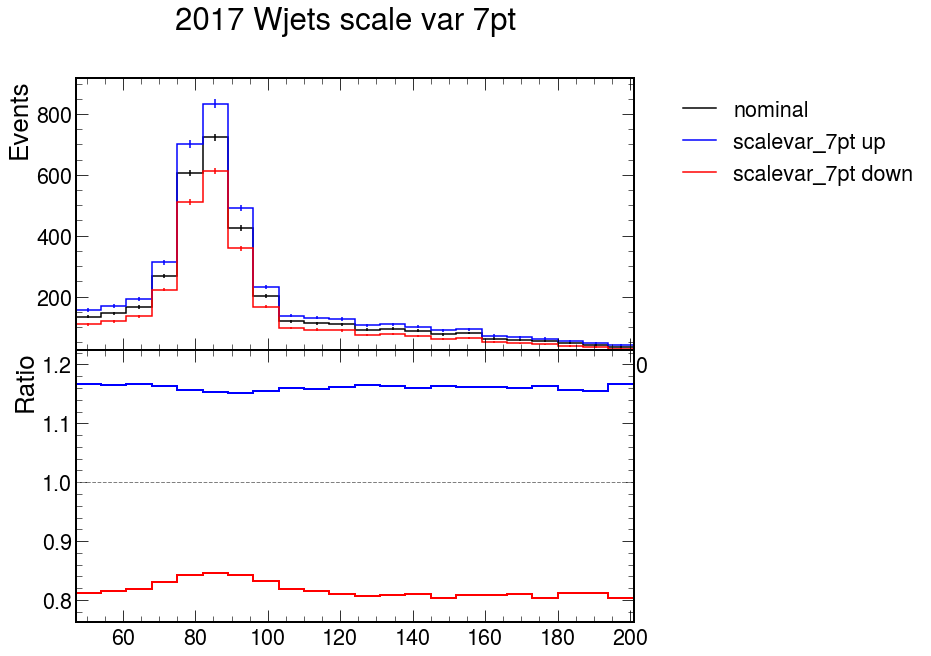

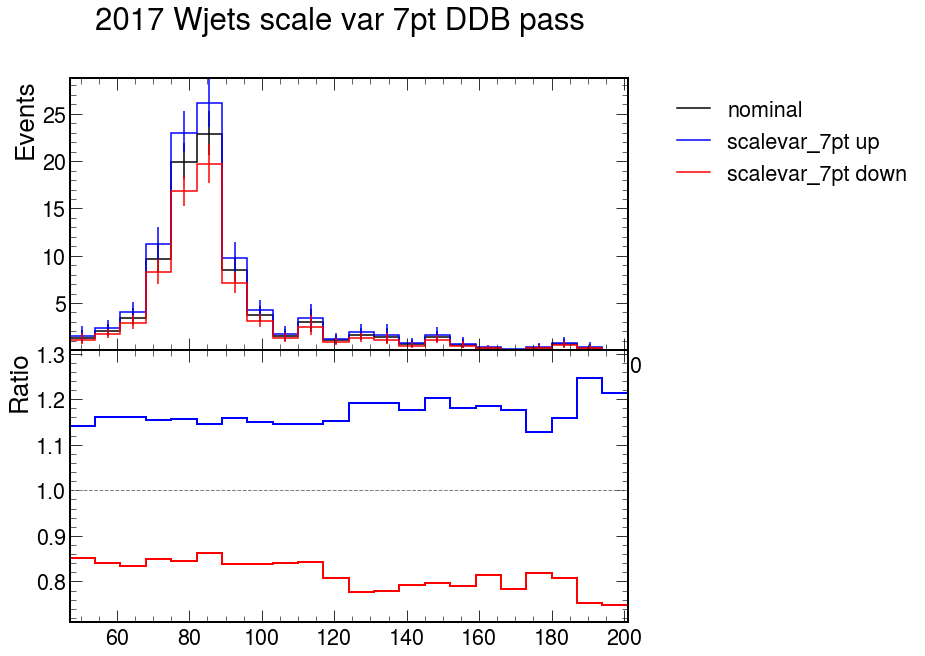

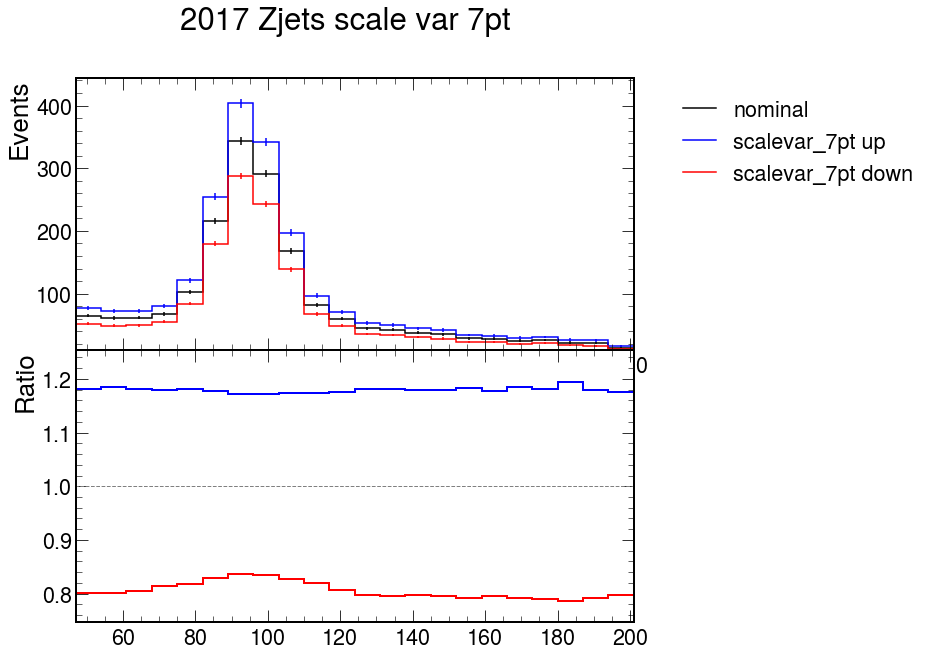

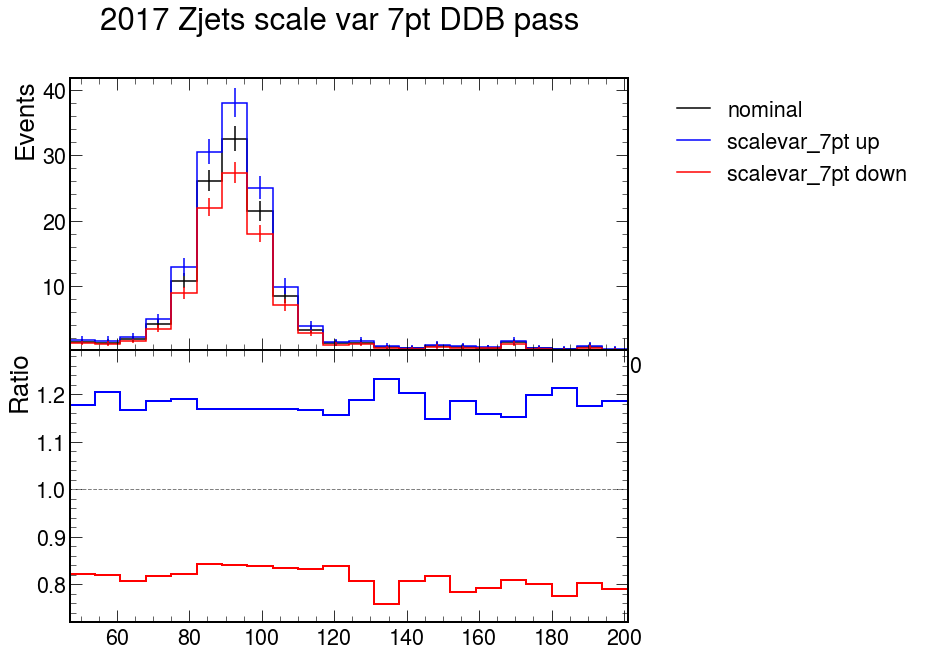

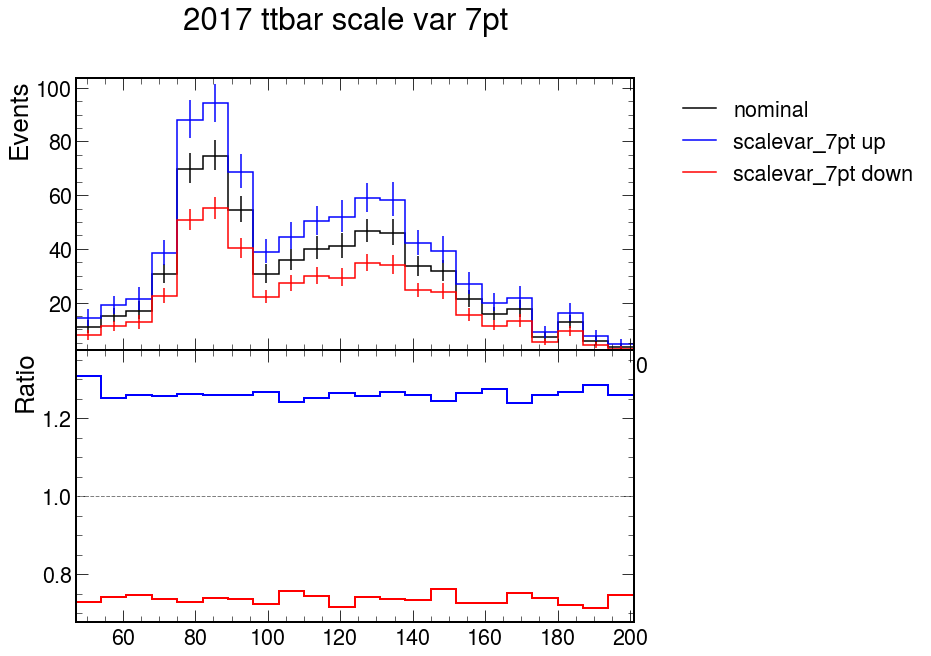

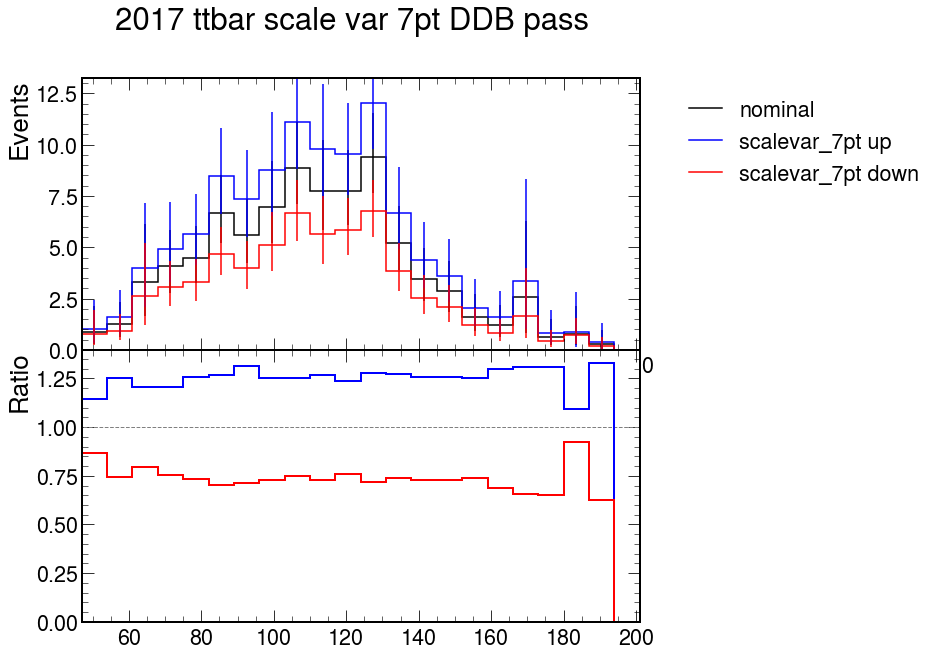

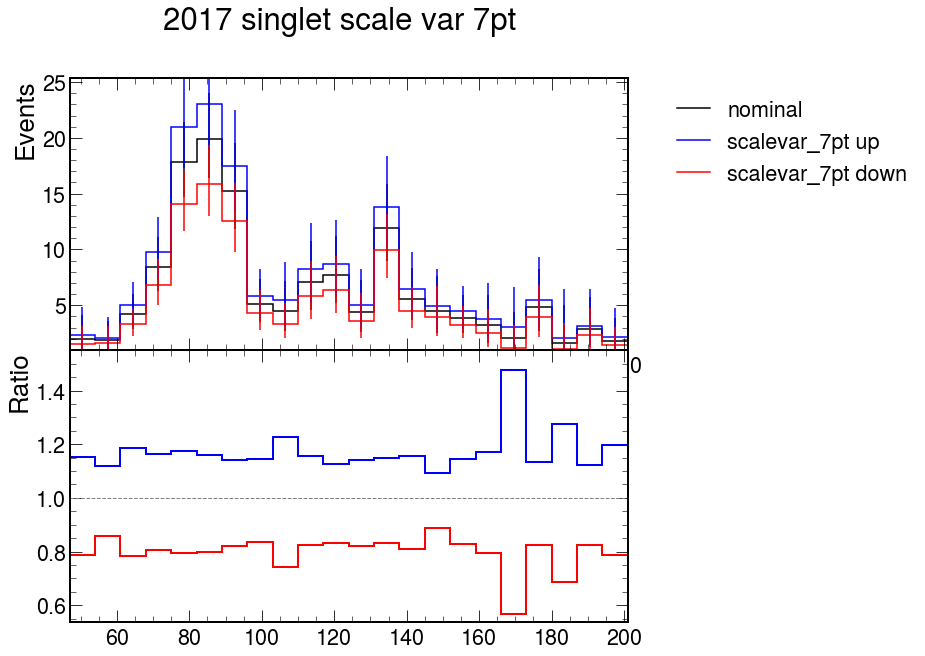

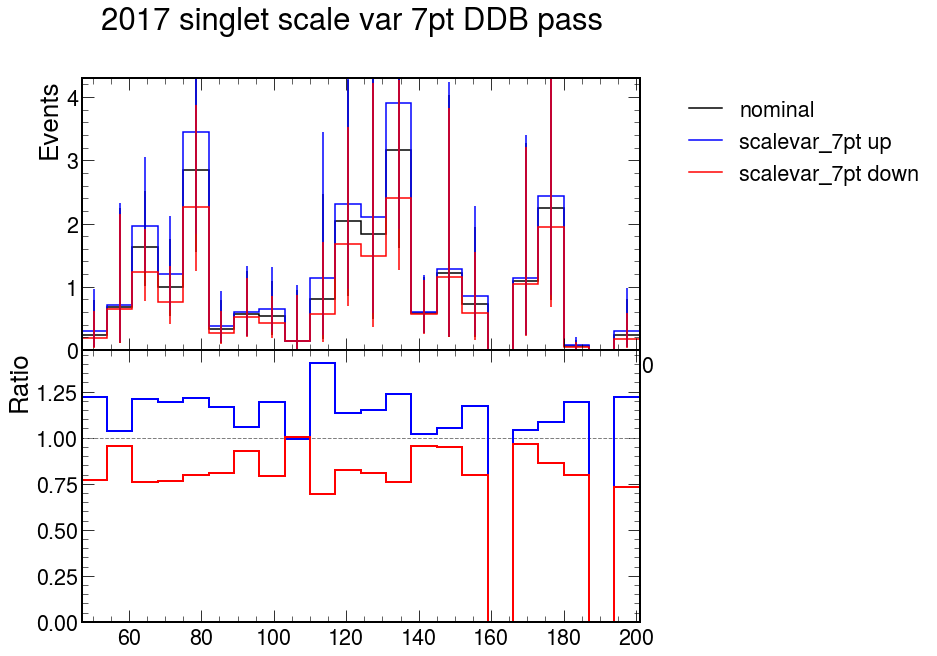

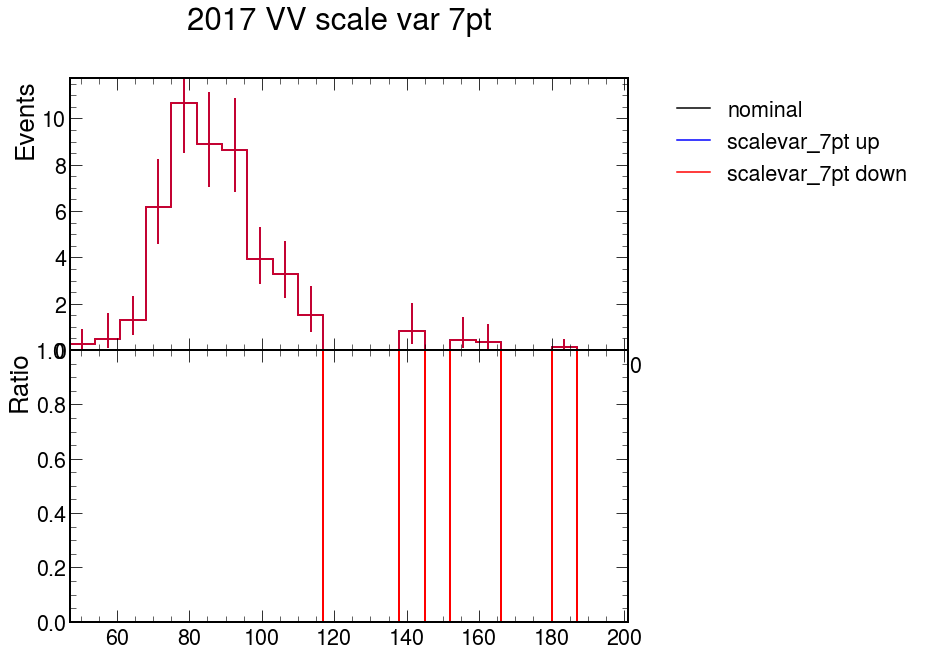

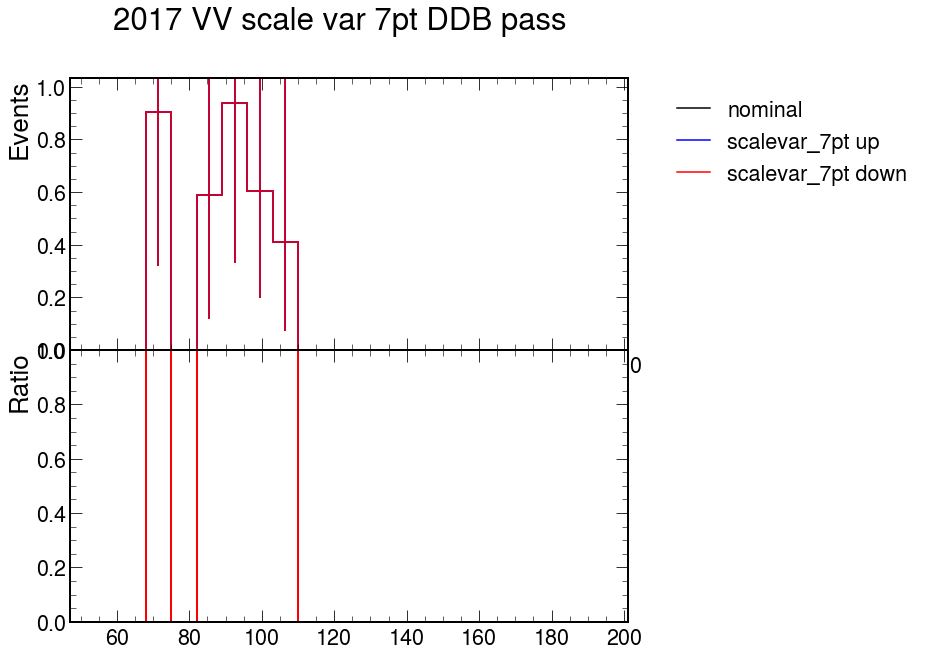

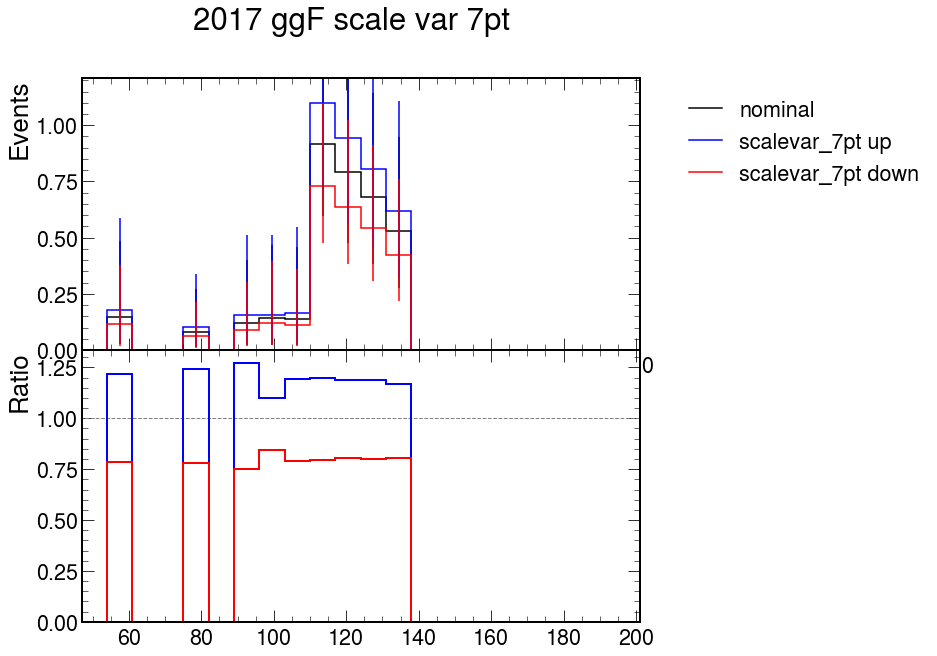

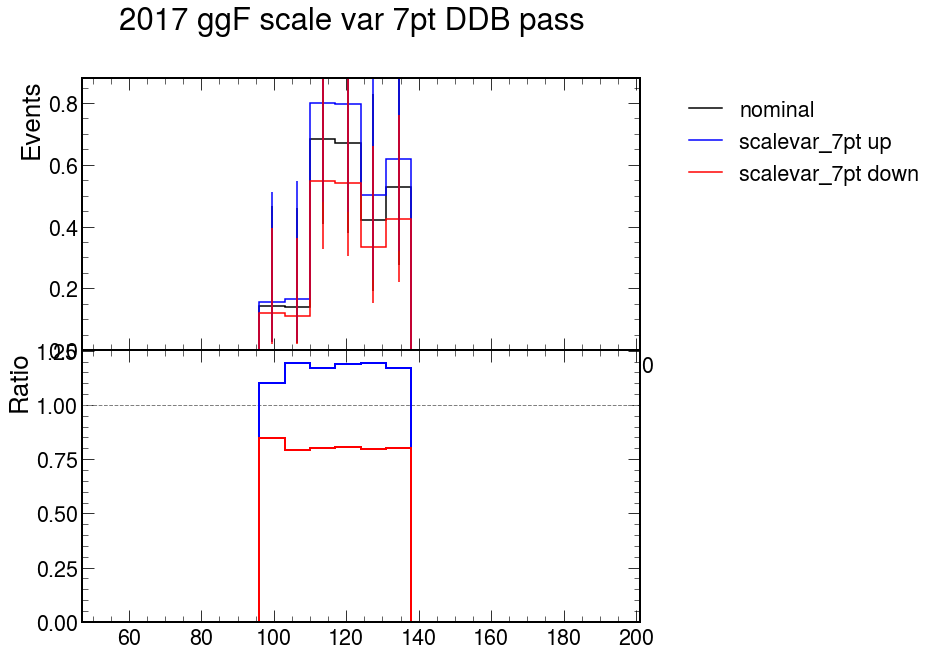

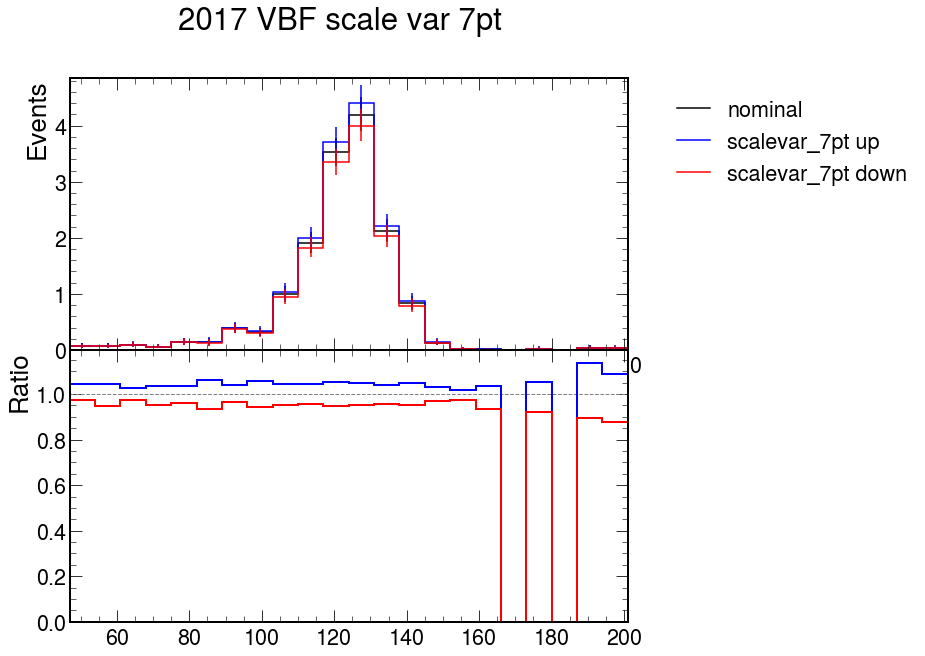

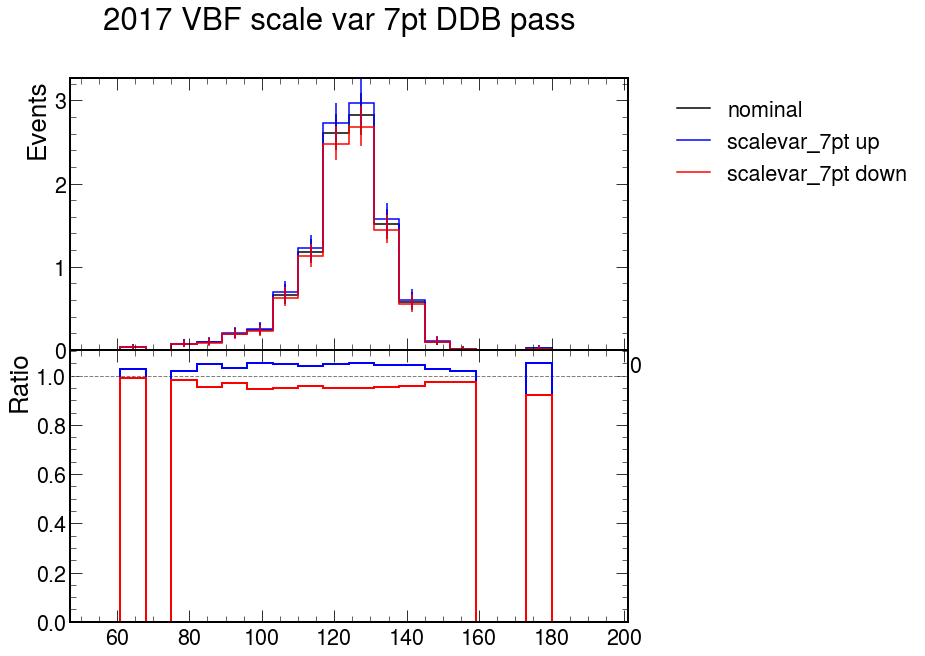

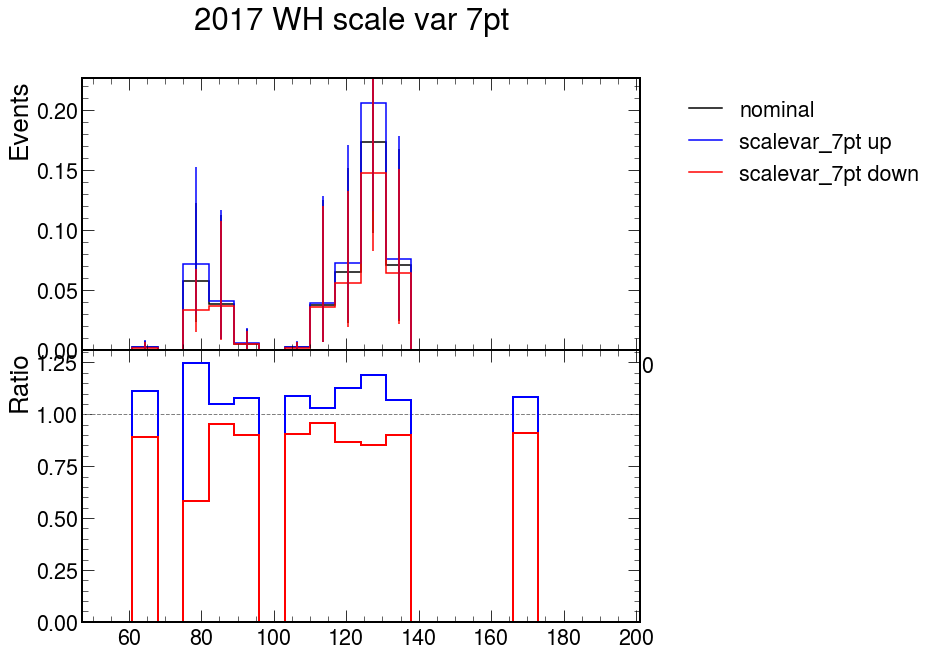

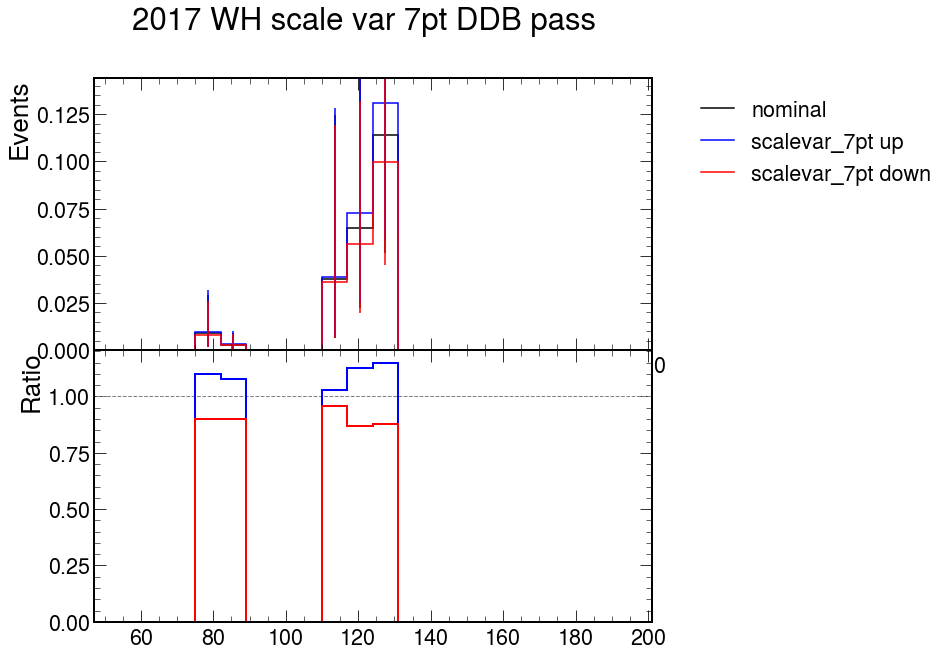

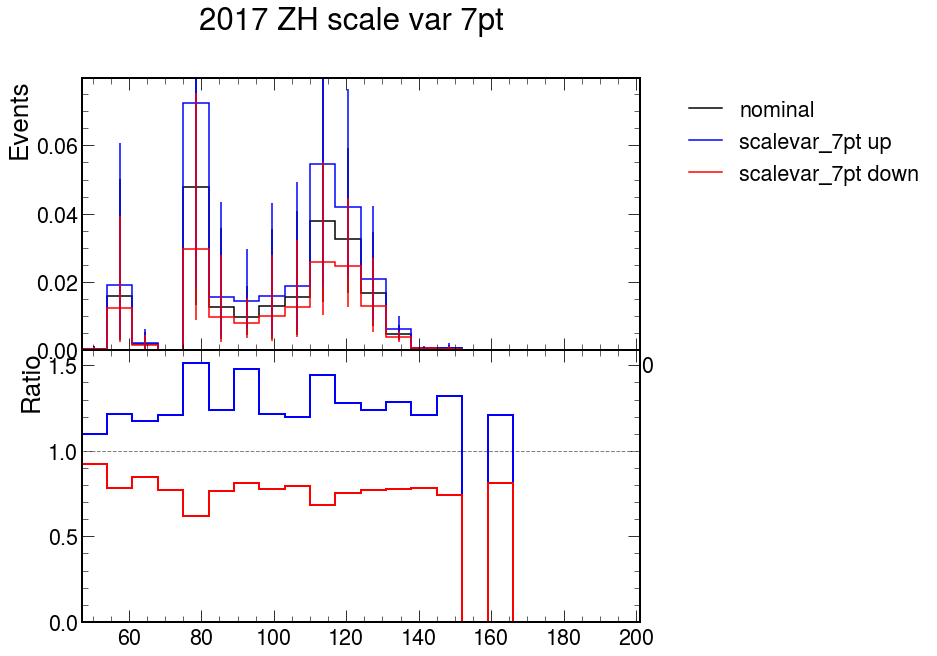

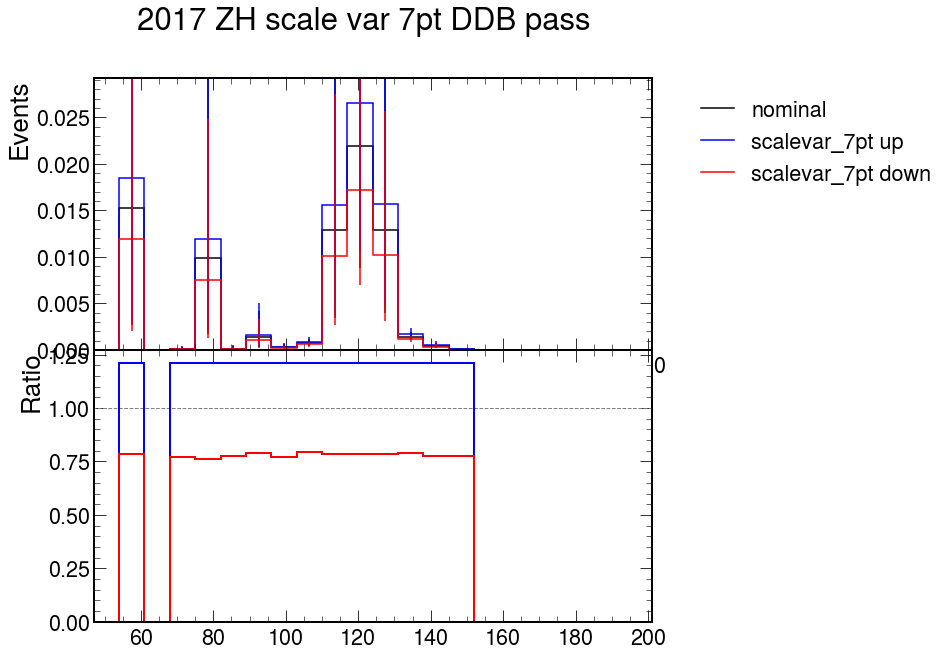

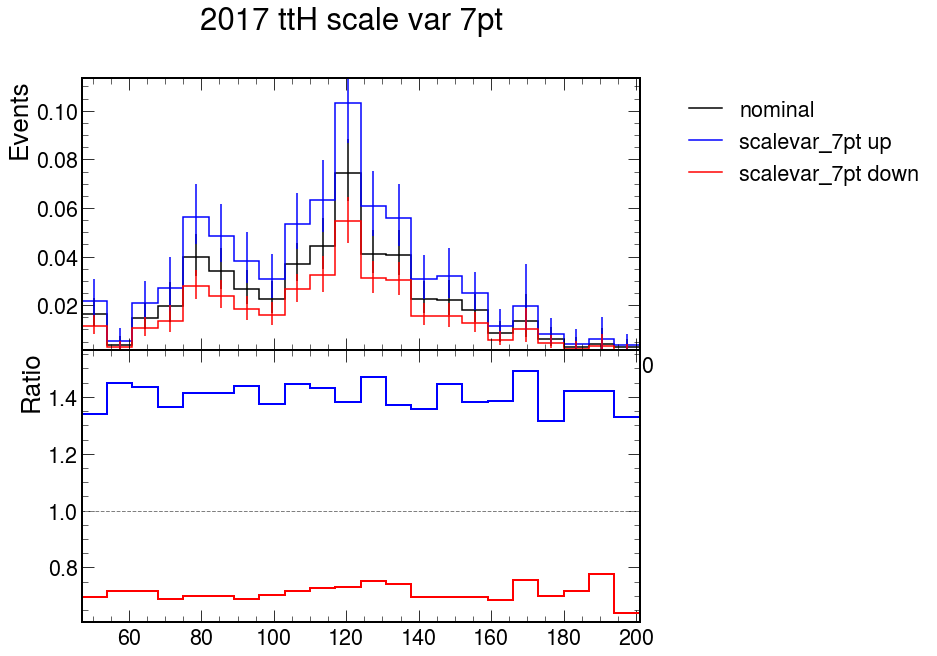

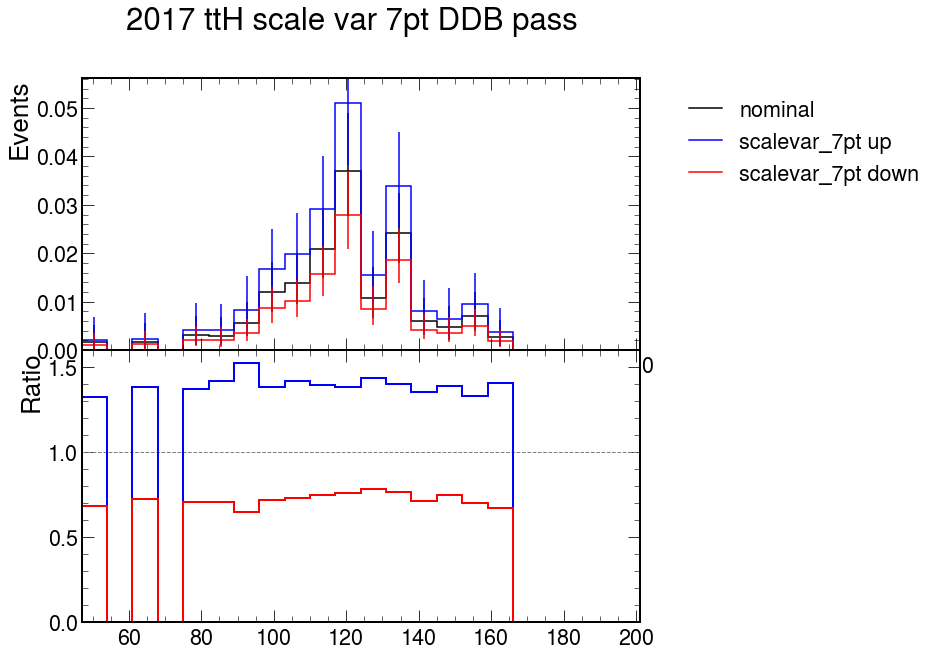

In [30]:
for p in mc:
    plot_syst(h.integrate('process',p),'scalevar_7pt',year+' '+p + ' scale var 7pt',year+'/syst_scalevar_7pt/'+p)
    plot_syst(g.integrate('process',p),'scalevar_7pt',year + ' ' + p + ' scale var 7pt DDB pass', year+'/syst_scalevar_7pt/'+p+"_pass")

/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:96: RuntimeWarning: invalid value encountered in double_scalars
  up_ratio = np.array([up_array[i]/nom_array[i] for i in range(len(nom_array))])
/srv/vbf-category/plotter.py:97: RuntimeWarning: invalid value encountered in double_scalars
  do_ratio = np.array([do_array[i]/no

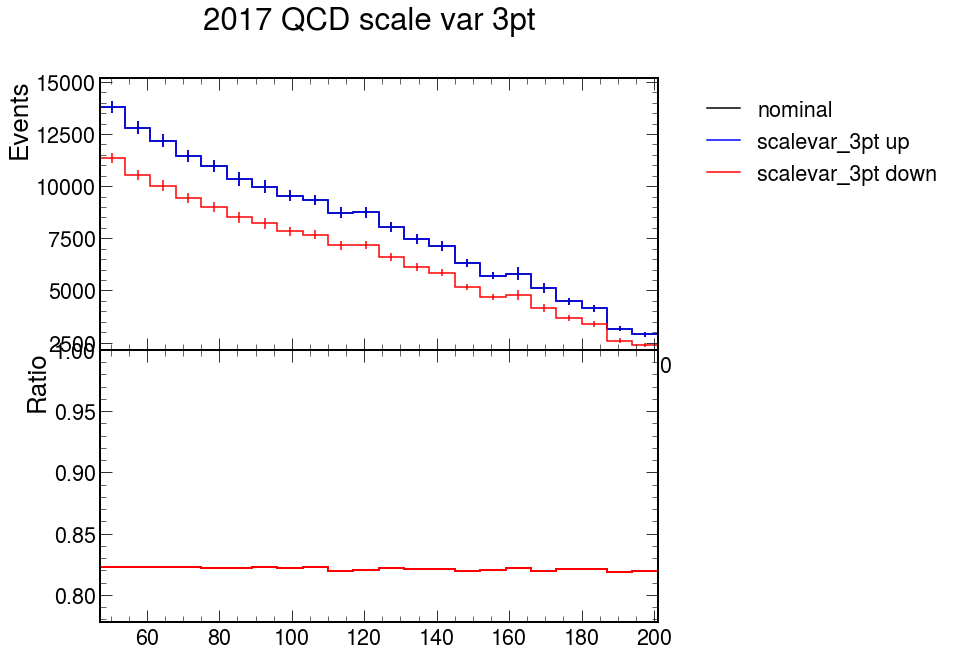

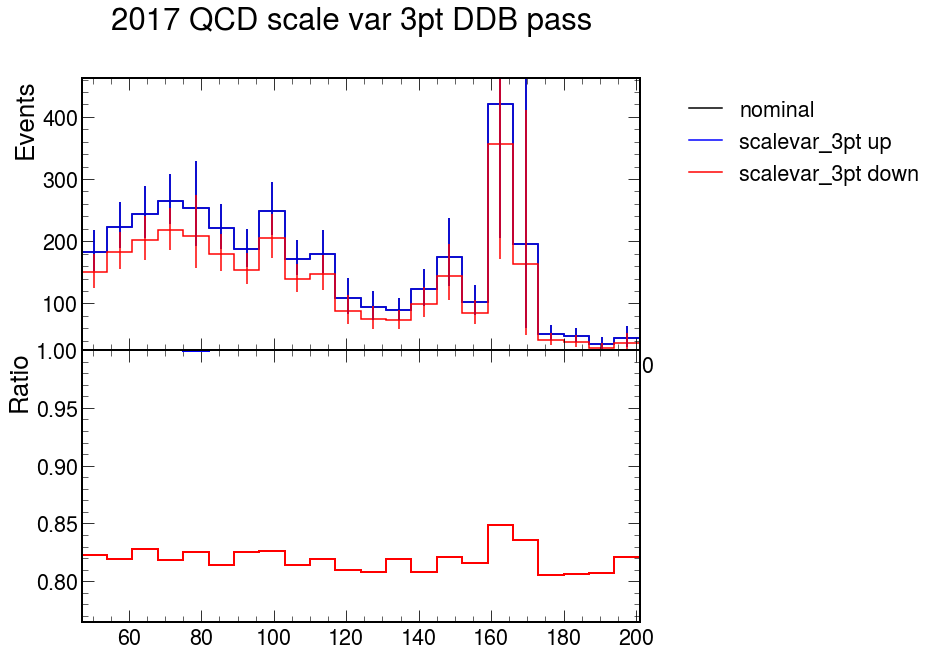

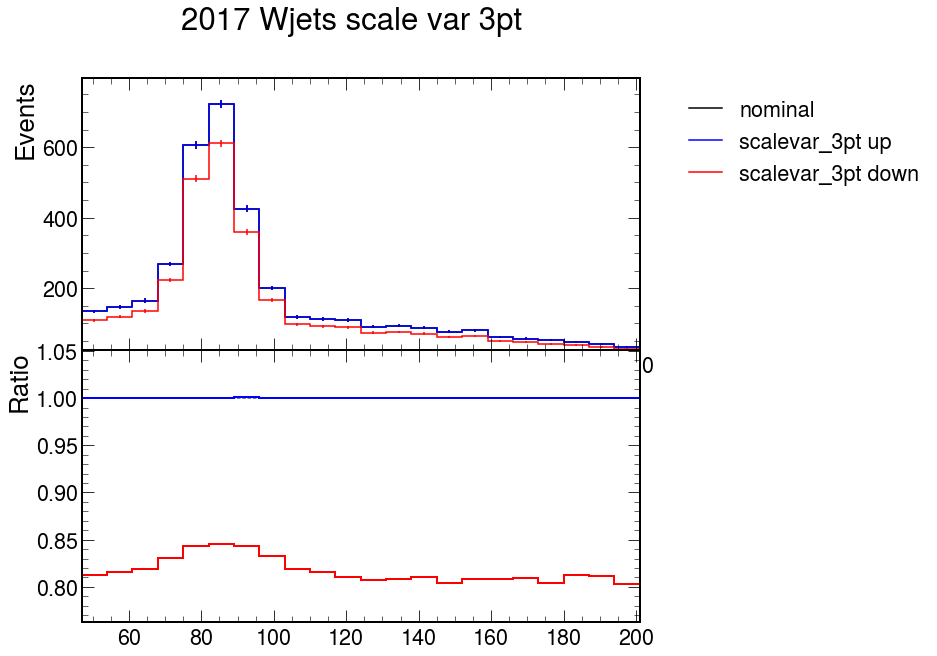

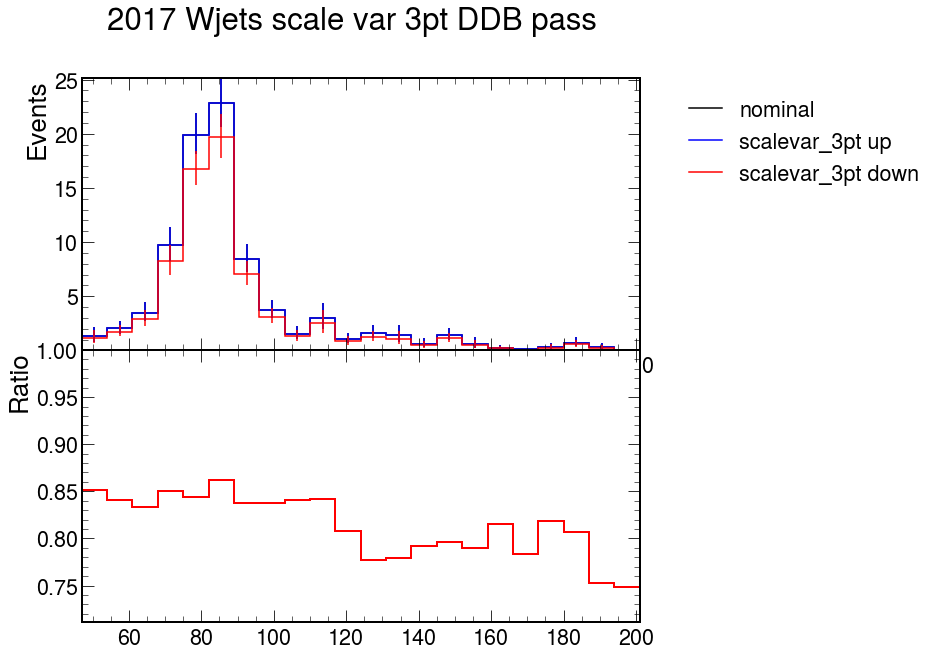

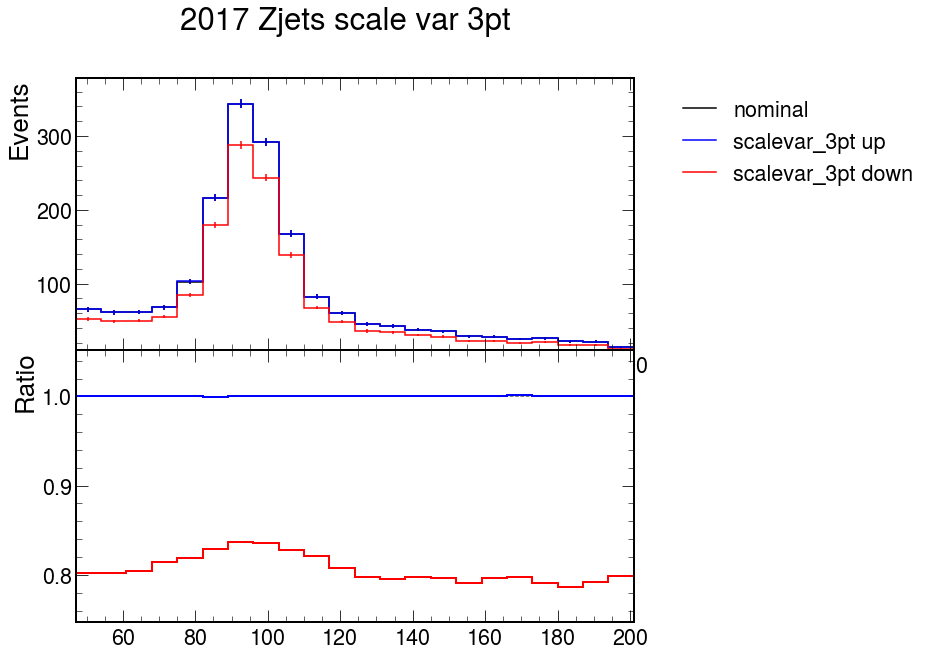

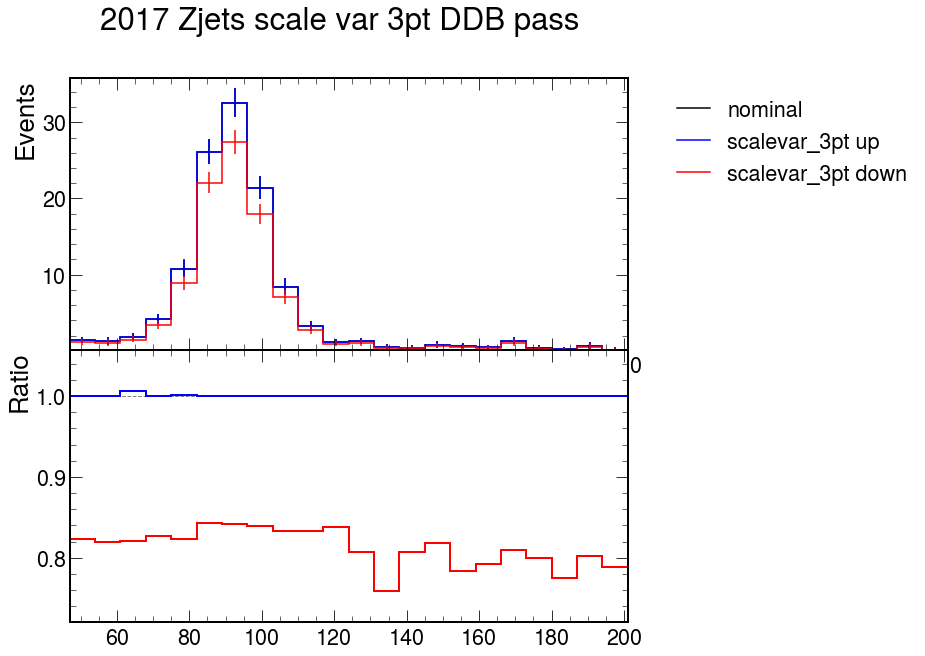

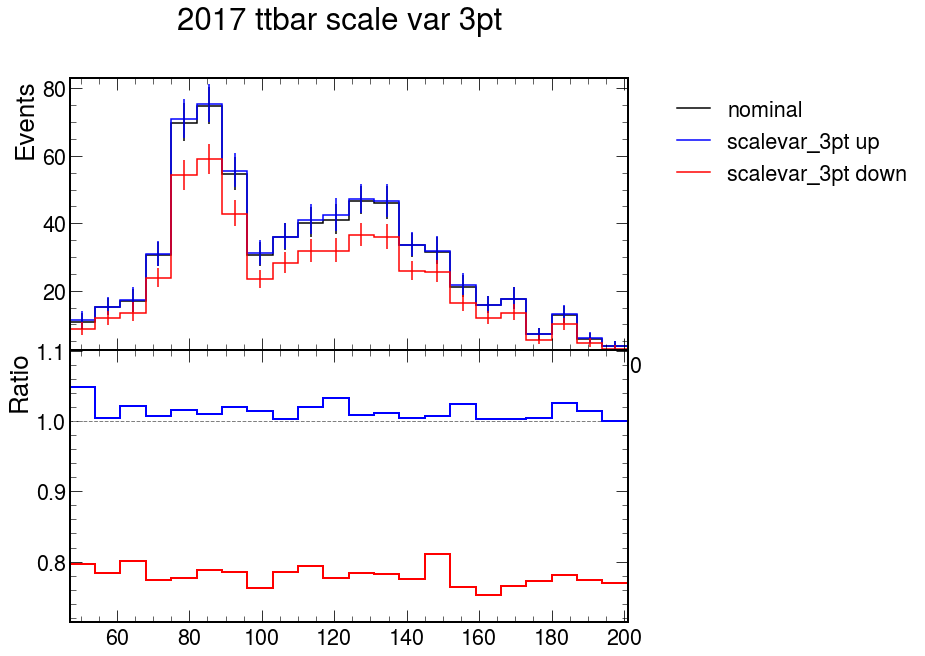

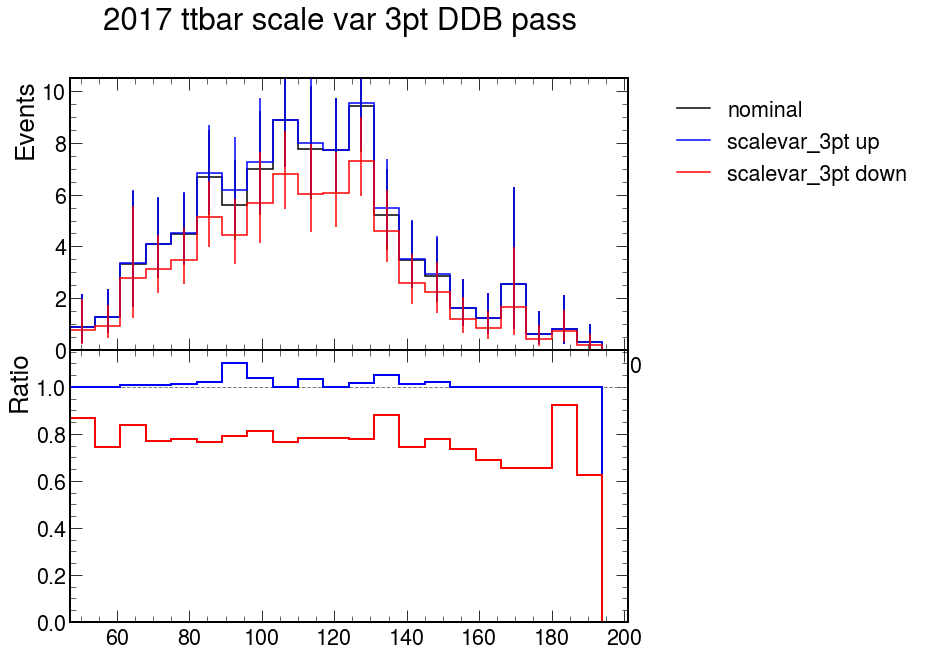

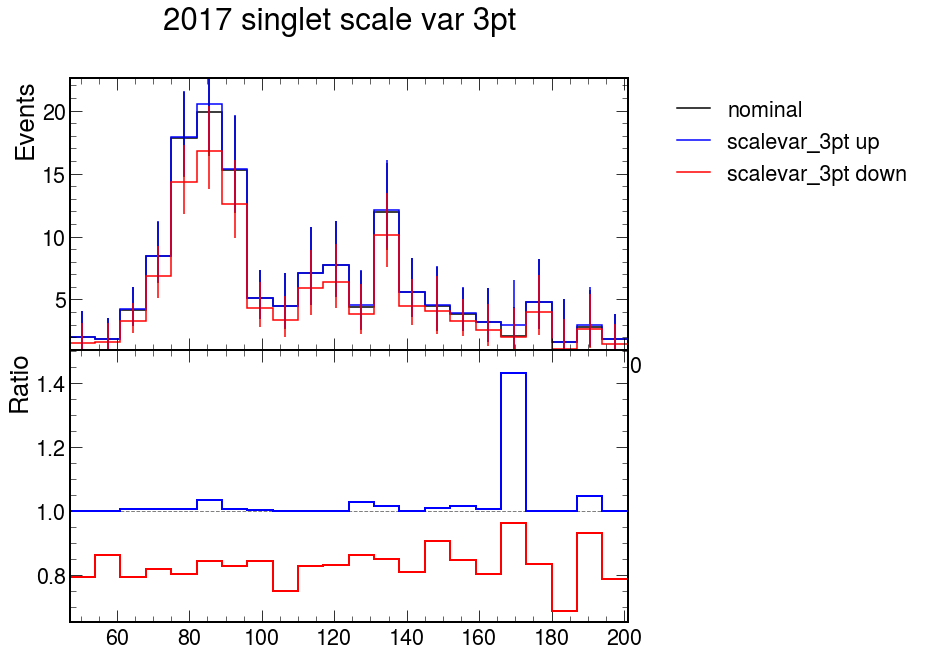

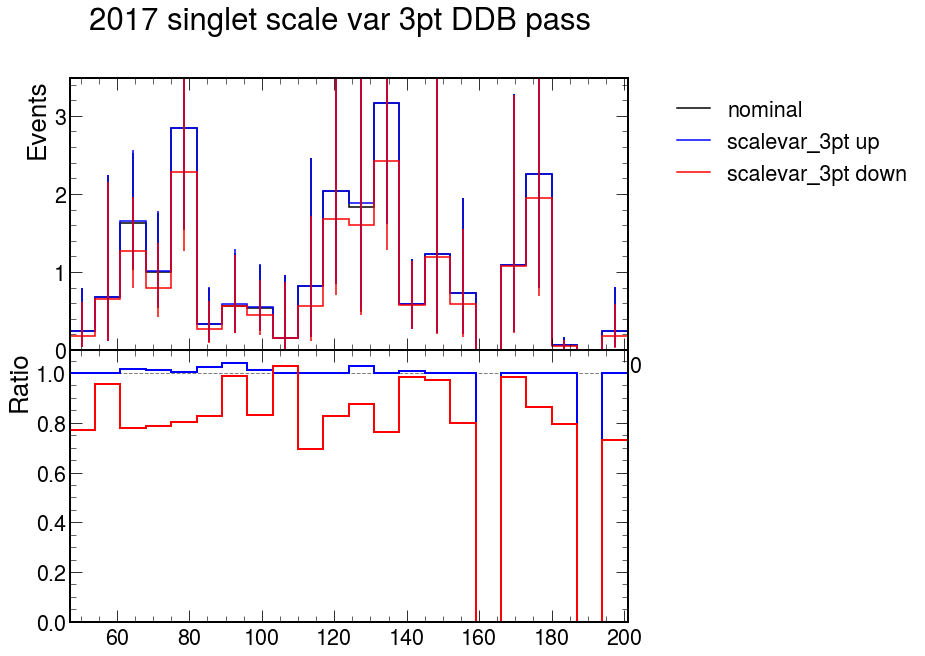

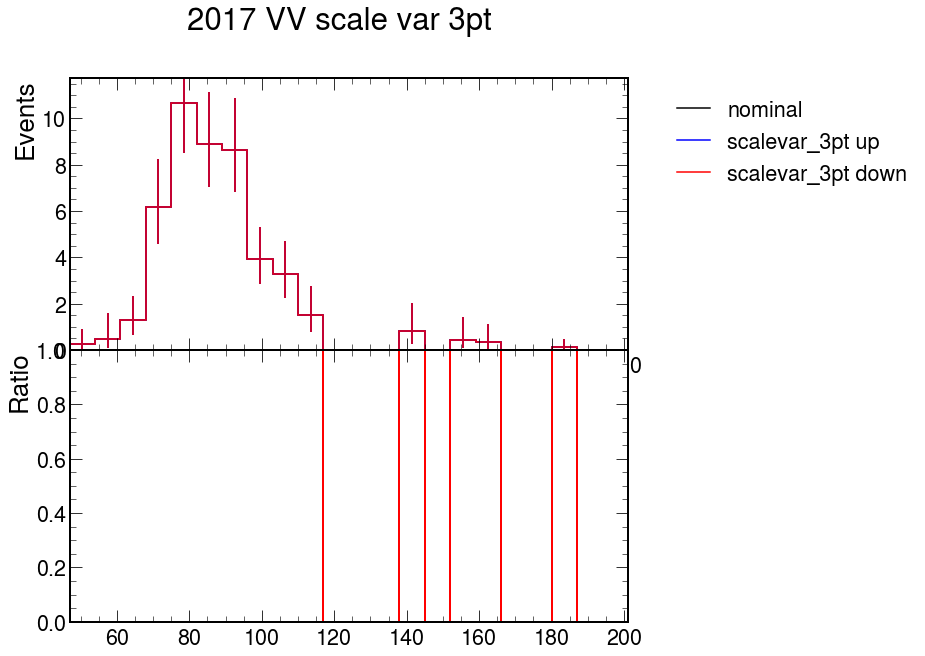

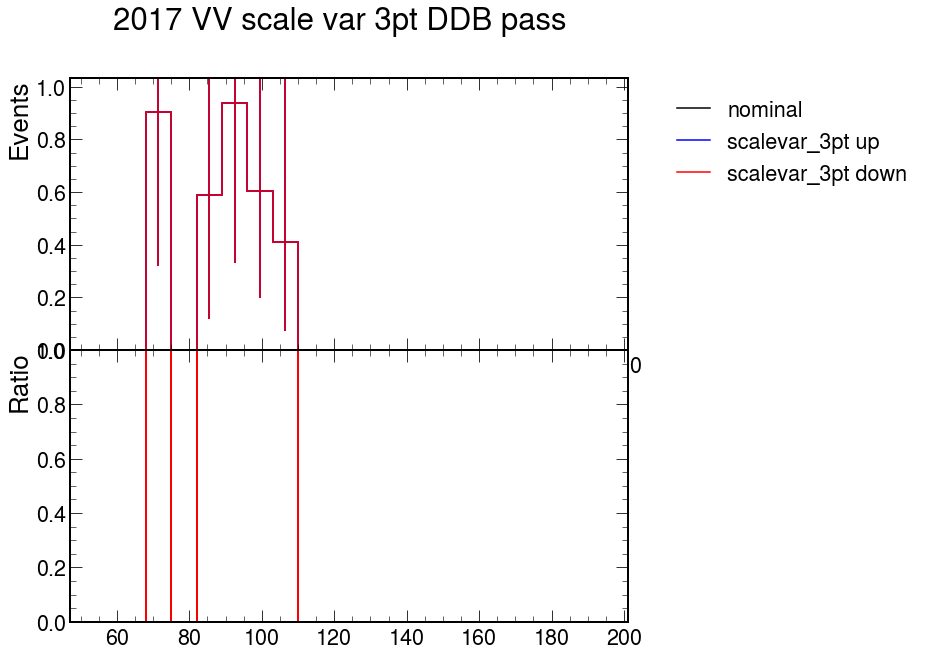

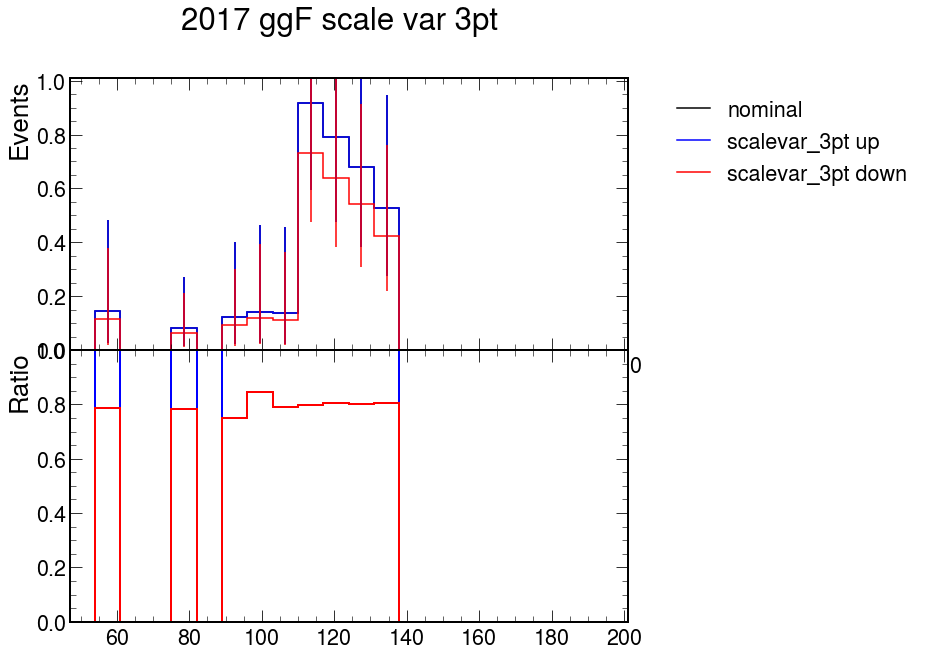

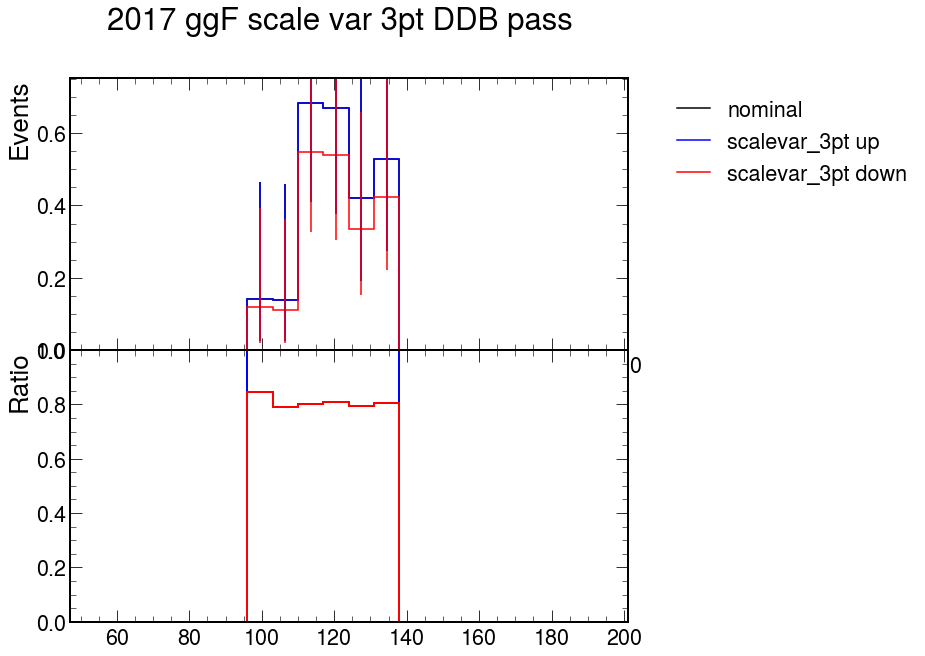

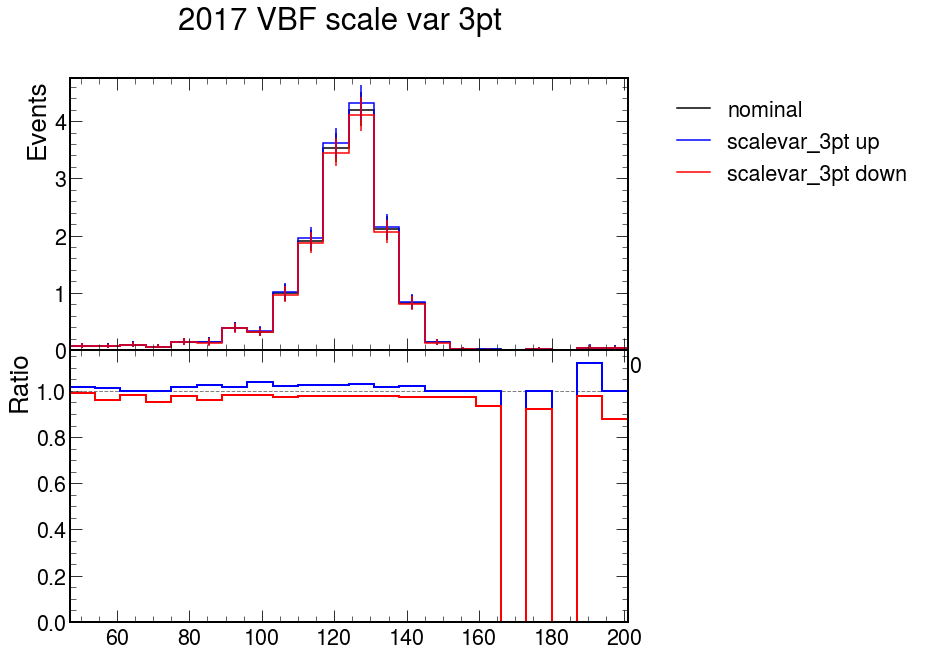

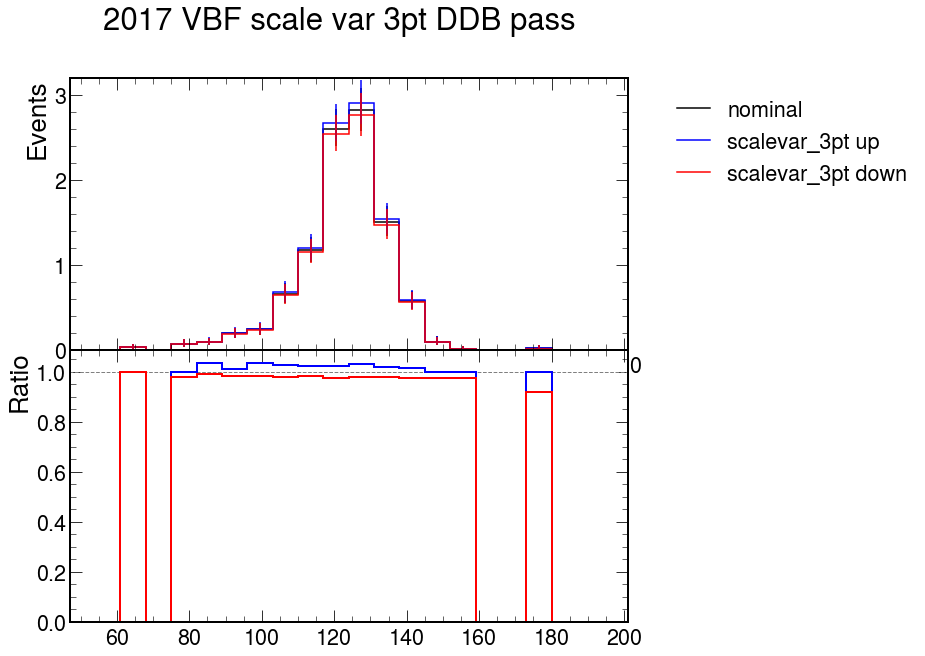

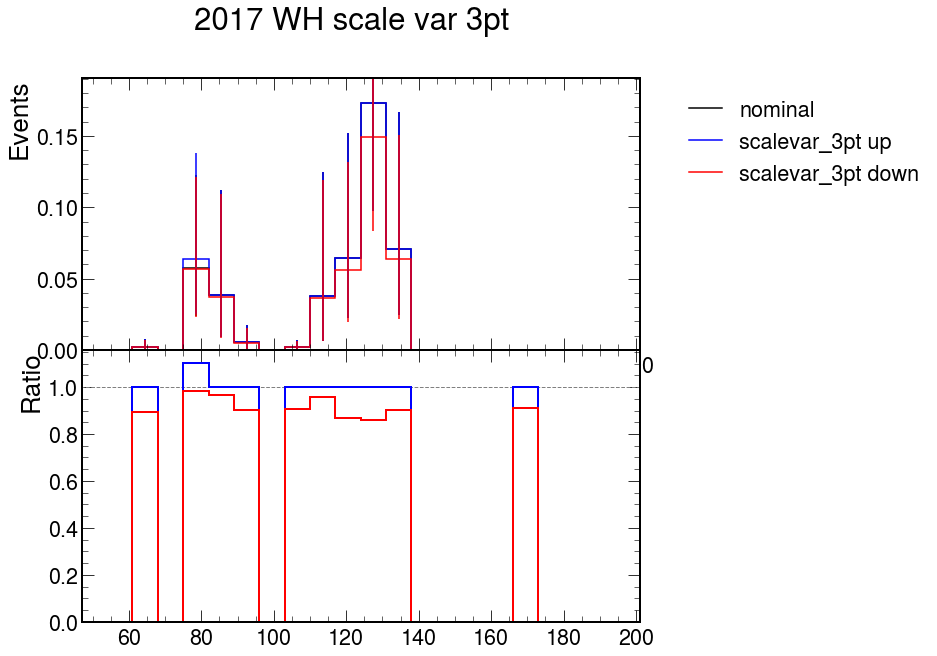

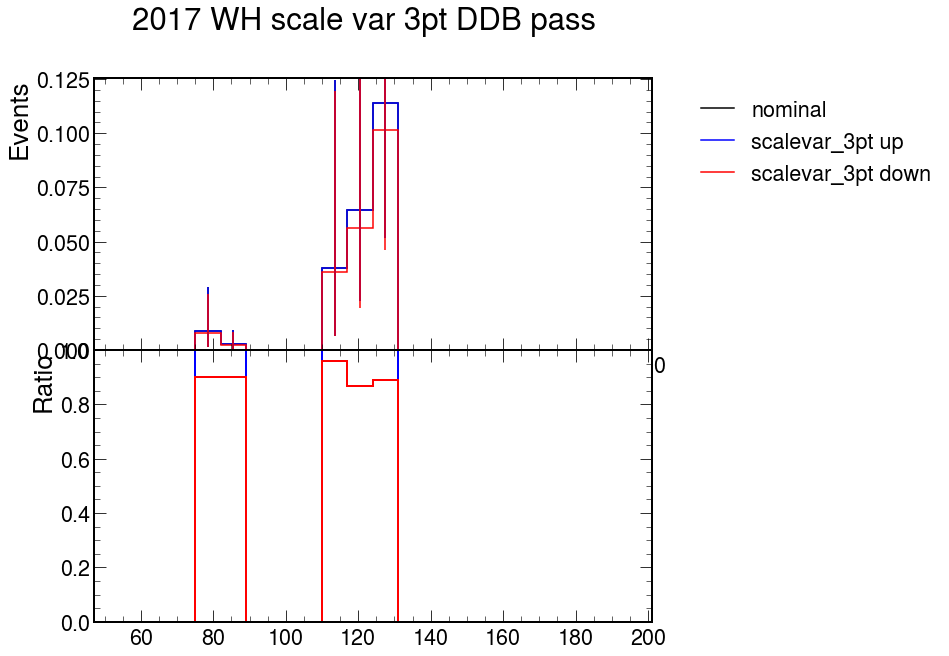

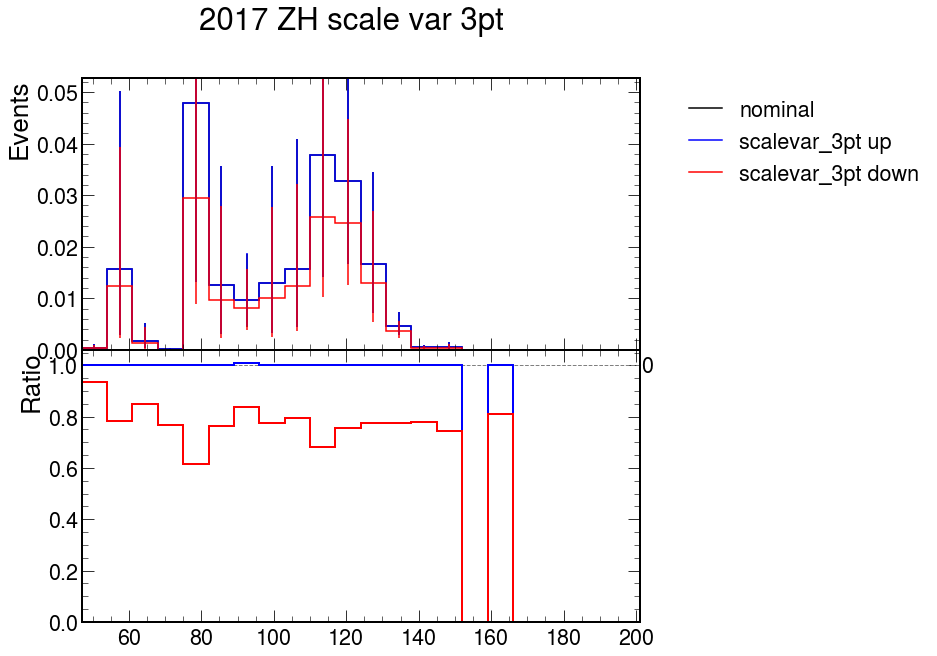

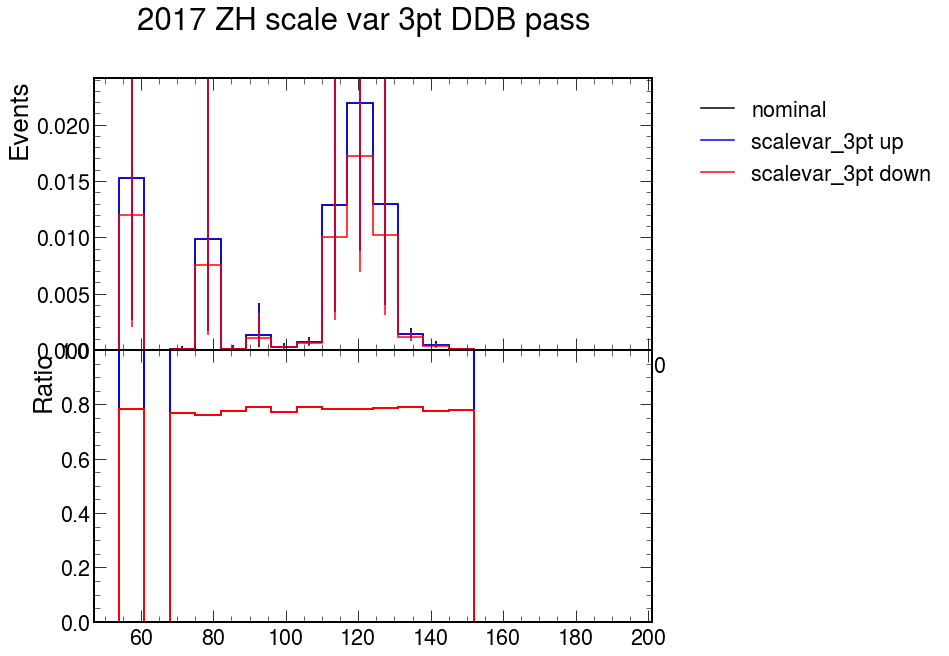

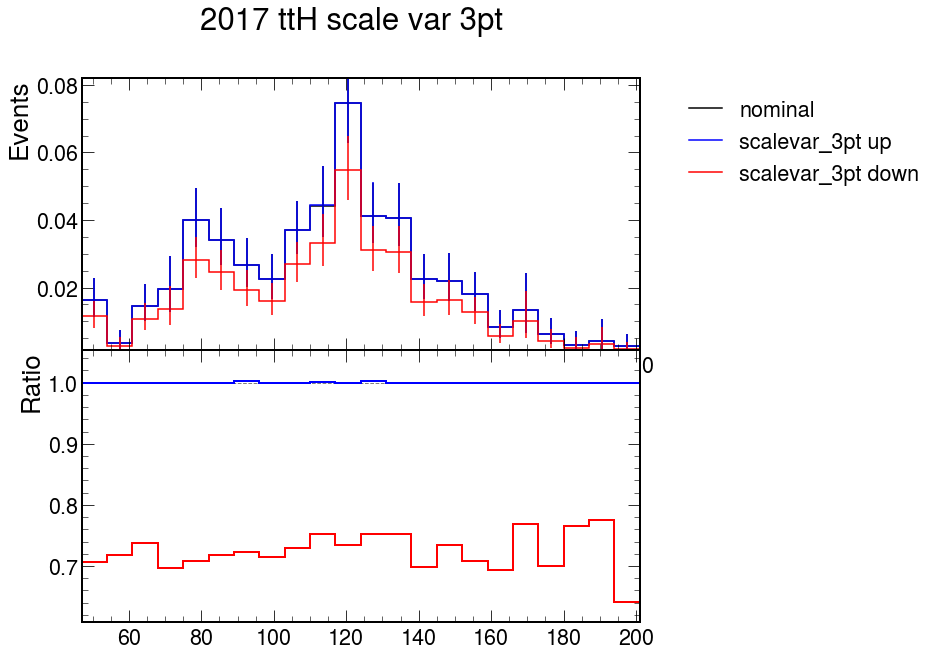

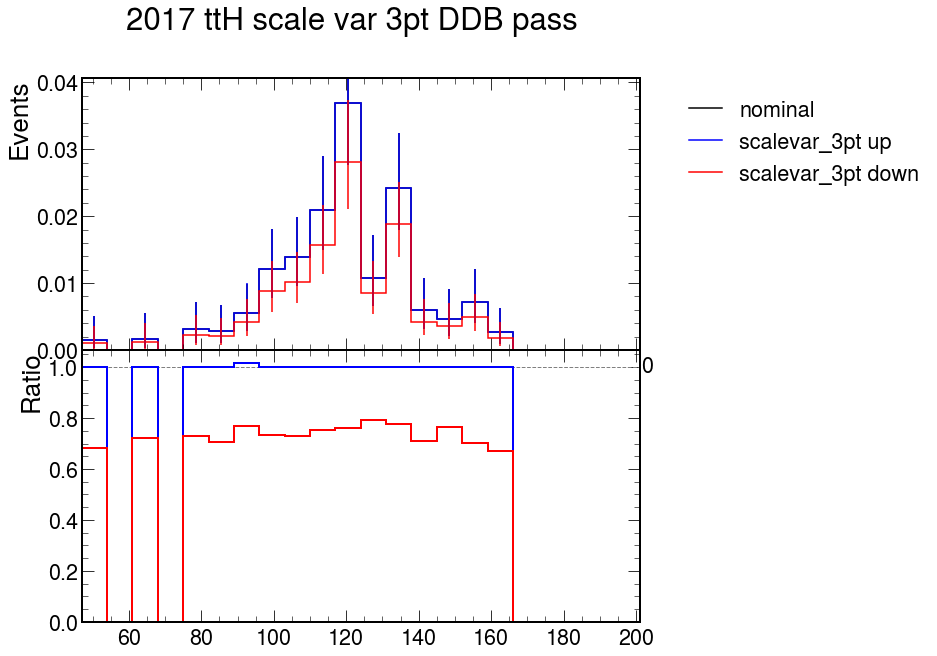

In [31]:
for p in mc:
    plot_syst(h.integrate('process',p),'scalevar_3pt',year+' '+p + ' scale var 3pt',year+'/syst_scalevar_3pt/'+p)
    plot_syst(g.integrate('process',p),'scalevar_3pt',year + ' ' + p + ' scale var 3pt DDB pass', year+'/syst_scalevar_3pt/'+p+"_pass")